In [17]:
# -*- coding: Paper1 -*-
"""
This code belongs to the paper:
-- An Iterative Gradient Descent-Based Reinforcement Learning Policy 
   for Active Control of Structural Vibrations, Computers & Structures.
-- Jagajyoti Panda, Mudit Chopra, Vasant Matsagar, Souvik Chakraborty, IIT Delhi.
   
This code is to present RL-based control algorithm in proportional-integral (PI) to state-output feedback.
-- Case study I: Quarter car model 
   State-space representation, Policy parameter update, Efficacy of trained RL-controller
"""
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import os
from numpy import abs as Abs
from numpy import sign as sign
from numpy import sqrt,pi,array
from scipy import signal
 
 
import matplotlib
import matplotlib.pyplot as plt

from control.matlab import *  # MATLAB-like functions
import control as ct
 
import tensorflow as tf
from gym import Env
from gym.spaces import Discrete, Box
 
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [18]:
# Quarter car model
M = 600  # Body mass (in Kg)
m = 75  # Mass of tyre (in Kg)
Ks = 30  # Spring constant
Cs = 400  # Damping coefficient
Kt = 300  # Spring constant of wheel
n = 2  # DOF
r = 1  # No of Actuator

# MR Damper
V = 20
K1 = 542.18
K2 = 550.16
C1 = 999.4
C2 = 3387.5
alpha  = 3846.2 
beta = 126.84
gamma = 303.83 
A1 = 96.067
N = 3

# State space representation (states - y1, y2, dot(y1), dot(y2)) 
# Continous time
A =np.array([[0 ,0 ,1 ,0 ],
              [0 ,0 ,0 ,1 ],
              [-Ks/M, Ks/M, 0, 0],
              [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
print(A)
# Input matrix (Control force and Earthquake input)
B  = np.array([[0,0,1/M,-1/m]]).T
print(B)
# Influence vector (Earthquake input)
E = np.array([[0,0,0,Kt/m]]).T 
print(E)
# Output matrix (Disp + Accel)
Cd = np.array([[1, 1, 0, 0], [-Ks/M, Ks/M, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0]])
print(Cd)
Dd = np.array([[0, 1/M, -1/m]]).T
print(Dd)
Ed = np.array([[0, 0, 0]]).T
print(Ed)

[[ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]
 [-0.05  0.05  0.    0.  ]
 [ 0.4  -4.4   0.    0.  ]]
[[ 0.        ]
 [ 0.        ]
 [ 0.00166667]
 [-0.01333333]]
[[0.]
 [0.]
 [0.]
 [4.]]
[[ 1.    1.    0.    0.  ]
 [-0.05  0.05  0.    0.  ]
 [ 0.4  -4.4   0.    0.  ]]
[[ 0.        ]
 [ 0.00166667]
 [-0.01333333]]
[[0]
 [0]
 [0]]


In [19]:
from numpy.linalg import matrix_rank
ko = matrix_rank(ctrb(A, B))
if ko == len(A):
  print("System is controllable")
else:
  print("System is uncontrollable")
del ko

System is controllable


Text(0, 0.5, 'Input(m)')

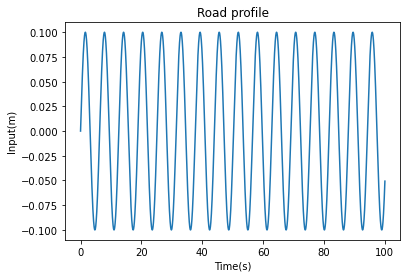

In [20]:
# Input Road Profile
T = 100
dt = 0.01
t = np.arange(0, T+dt, dt)
omega = 1
amplitude   = 0.1*np.sin(omega*t)
len(t)
plt.figure()
plt.plot(t, amplitude)
plt.title('Road profile')
plt.xlabel('Time(s)')
plt.ylabel('Input(m)')

In [21]:
input = np.array([t,amplitude])
print(input.T.shape)
result=np.savetxt('time.txt', input.T, delimiter=' ')
print(result)

(10001, 2)
None


In [22]:
# Discrete time matrices
Ad = np.identity(2*n)
I = np.identity(2*n)
fact = 1
for x in range(1, 20):
    fact = fact * x
    Ad = Ad + ((A**x)*((dt**x)/fact))
    
Bd = (Ad-I)@np.linalg.inv(A)@B
Ed = (Ad-I)@np.linalg.inv(A)@E
print(Ad, Bd, Ed) 
del I, x

[[ 1.00000000e+00  0.00000000e+00  1.00501671e-02  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00501671e-02]
 [-4.99875021e-04  5.00125021e-04  1.00000000e+00  0.00000000e+00]
 [ 4.00801068e-03 -4.30460425e-02  0.00000000e+00  1.00000000e+00]] [[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.66625007e-05]
 [-1.33600356e-04]] [[ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.50000005e-07]
 [ 3.90380318e-02]]


In [24]:
# System State Space 
# PI controller (continous)
FIc = np.zeros((2*n+r,2*n+r))
FIc[0:2*n,0:2*n] = A
FIc[2*n,0:2*n] = -Cd[0,:]
print(FIc)
gIc = np.zeros((2*n+r,r))
gIc[0:2*n,:] = B
print(gIc)
BIrdc = np.zeros((2*n+r,r))
BIrdc[0:2*n,:] = E
print(BIrdc)
# Discrete
FI = np.zeros((2*n+r,2*n+r))
FI[0:2*n,0:2*n] = Ad
FI[2*n,0:2*n] = Cd[0,:] @ Ad
FI[2*n,2*n] = np.identity(r)
print(FI)
gI = np.zeros((2*n+r,r))
gI[0:2*n,:] = Bd
gI[2*n,:] = Cd[0,:] @ Bd
print(gI)
BIrd = np.zeros((2*n+r,r))
BIrd[0:2*n,:] = Ed
BIrd[2*n,:] = Cd[0,:] @ Ed
print(BIrd)
# Output of PI controller
Cdi = np.zeros((n+r,2*n+r))
Cdi[0:n,0:2*n] = Cd[1:n+1,:]
Cdi[n,2*n] = np.identity(r)
print(Cdi)
Ddi = np.zeros((n+r,r))
Ddi[0:n,:] = Dd[1:n+1,:]
print(Ddi)
ko = matrix_rank(ctrb(FIc, gIc))
if ko == len(FIc):
  print("System is controllable")
else:
  print("System is uncontrollable")
del ko

[[ 0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    1.    0.  ]
 [-0.05  0.05  0.    0.    0.  ]
 [ 0.4  -4.4   0.    0.    0.  ]
 [-1.   -1.   -0.   -0.    0.  ]]
[[ 0.        ]
 [ 0.        ]
 [ 0.00166667]
 [-0.01333333]
 [ 0.        ]]
[[0.]
 [0.]
 [0.]
 [4.]
 [0.]]
[[ 1.00000000e+00  0.00000000e+00  1.00501671e-02  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00501671e-02
   0.00000000e+00]
 [-4.99875021e-04  5.00125021e-04  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.00801068e-03 -4.30460425e-02  0.00000000e+00  1.00000000e+00
   0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00501671e-02  1.00501671e-02
   1.00000000e+00]]
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.66625007e-05]
 [-1.33600356e-04]
 [ 0.00000000e+00]]
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.50000005e-07]
 [ 3.90380318e-02]
 [ 0.00000000e+00]]
[[-0.05  0.05  0.    0.    0.  ]
 [ 0.4  -4.4   0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.  ]]
[[ 0.0016

In [28]:
# Propertional (Continous)
Qp = np.array([[Ks, -Ks, 0, 0],
            [-Ks, Ks+Kt, 0, 0],
            [0, 0, M, 0],
            [0, 0, 0, m]])
(i,j)=gI.shape
R = (10**(0))*np.identity(j)
Kp1, Sp1, ep1 = ct.lqr(A, B, Qp, R)
print(Kp1) # Continous time
xp1 = np.zeros((len(t),2*n))
yp1 = np.zeros((len(t),i))
sys_c = signal.StateSpace(A-B@Kp1, E, Cd-Dd@Kp1, np.array([[0, 0, 0]]).T)
t_c,yp1,xp1 = signal.lsim(sys_c,amplitude,t)

[[  0.49590136  -1.14546156  35.69758159 -11.83173935]]


In [29]:
# LQR design (propertional+Integral) (Case 1)
Qpi = np.zeros((2*n+r,2*n+r))
Qpi[0:2*n,0:2*n] = Qp
out = Cd[0,:] @ Qp
out_arr  = out[np.nonzero(out)]
# Qpi[2*n,2*n] = out_arr
Qpi[2*n,2*n] = Ks
# print(Qpi)
Kd, S, e = ct.dlqr(FI, gI, Qpi, R)
print(Kd)
Kdc, Sc, ec = ct.lqr(FIc, gIc, Qpi, R)
print(Kdc)

# LQR design (propertional+Integral) (Case 2)
Q2 = (Cdi.T) @ np.identity(n+r) @ Cdi
W2 = (Cdi.T) @ np.identity(n+r) @ Ddi
R2 = ((Ddi.T) @ np.identity(n+r) @ Ddi) + R 
Q_bar = Q2 - (W2 @ np.linalg.inv(R2) @ W2.T)
FIc_bar = FIc - (gIc @ np.linalg.inv(R2) @ W2.T)
Kda1c, Sa, ea = ct.lqr(FIc_bar, gIc, Q_bar, R2)
Kdac = Kda1c + (np.linalg.inv(R2) @ W2.T)
print(Kdac)

FI_bar = FI - (gI @ np.linalg.inv(R2) @ W2.T)
Kda1, Sa, ea = ct.dlqr(FI_bar, gI, Q_bar, R2)
Kda = Kda1 + (np.linalg.inv(R2) @ W2.T)
print(Kda)
del S, e, Sa, ea
np.save('Qpi.npy', Qpi)
np.save('ControllerPI_QC.npy', Kdc)

[[1928.69694078 -249.55552067 3593.43398159  175.78956569    5.37845784]]
[[ 25.72063416  -3.6930903  198.53017206  -8.65909908  -5.47722558]]
[[ 1.52915697 -0.09845704 47.12935926 -1.34434684 -0.99990973]]
[[ 4.19076457e+02 -3.11531880e+01  1.01892635e+03  1.43743585e+01
   9.92409557e-01]]


(50, 3)
None


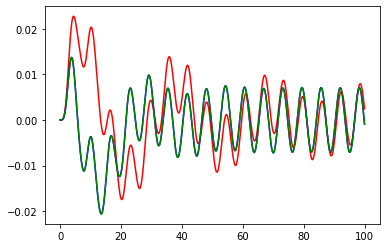

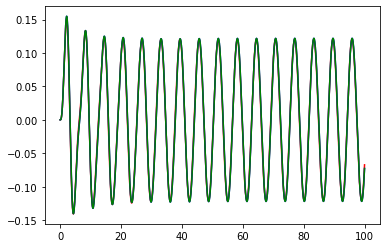

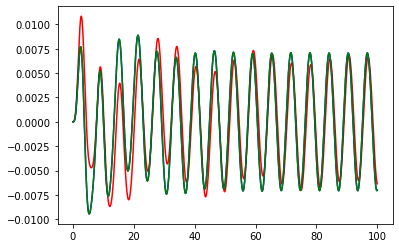

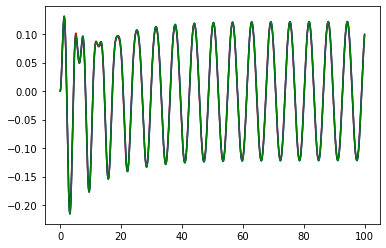

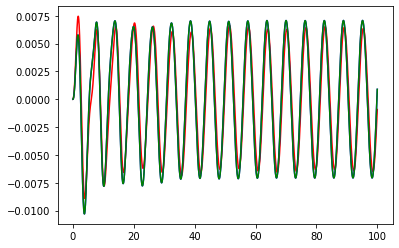

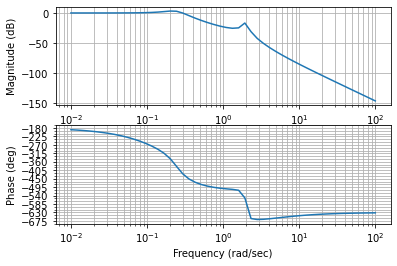

In [289]:
# Time series analysis (Continous)
xpi = np.zeros((len(t),2*n+r))
xpi1 = np.zeros((len(t),2*n+r))
(i,j) = Cdi.shape
ypi = np.zeros((len(t),i))
ypi1 = np.zeros((len(t),i))
del i,j

sys_c = signal.StateSpace(FIc-gIc@Kdc, BIrdc, Cdi-Ddi@Kdc, np.array([[0, 0, 0]]).T)
t_c,ypi,xpi = signal.lsim(sys_c,amplitude,t)

sys_c1 = signal.StateSpace(FIc_bar-gIc@Kdac, BIrdc, Cdi-Ddi@Kdac, np.array([[0, 0, 0]]).T)
t_c,ypi1,xpi1 = signal.lsim(sys_c,amplitude,t)

for i in range(0,2*n):
    plt.figure()
    plt.plot(t, xp1[:,i], 'r', t, xpi[:,i], 'b', t, xpi1[:,i], 'g')
del i 

for i in range(0,len(Cdi)-1):
    plt.figure()
    plt.plot(t, yp1[:,i+1], 'r', t, ypi[:,i], 'b', t, ypi1[:,i], 'g')
del i

mag_pc, phase_pc, om_pc = bode(ss(FIc-gIc@Kdc, BIrdc, np.array([1, 0, 0, 0, 0])-Ddi[2, :]@Kdc, np.array([0]).T), logspace(-2, 2), plot=True)


In [293]:
# Initial controller gain (proportional)
Qp = np.array([[1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])
Qpi_i = np.zeros((2*n+r,2*n+r))
Qpi_i[0:2*n,0:2*n] = Qp
Qpi_i[2*n,2*n] = 1
print(Qpi_i)
Kdc, S, e = ct.lqr(FIc, gIc, Qpi_i, R)
Kdac, S, e = ct.lqr(FIc_bar, gIc, Qpi_i, R)
Kd, S, e = ct.dlqr(FI, gI, Qpi_i, R)

print(Kdc, Kdac, Kd)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[ 1.88923872 -0.06830542 52.29405695 -0.29586056 -1.        ]] [[ 1.88954328 -0.06835856 52.2936457  -0.29691304 -1.        ]] [[ 4.32397026e+02 -3.46731389e+01  1.06744315e+03  1.71010293e+01
   9.92278333e-01]]


In [37]:
# PI controller (continous)
Bj_pi = gIc @ (-1*Kdc)
Al_pi = FIc.T + Bj_pi.T 
P_pi = lyap(Al_pi, -Qpi)
print(Bj_pi)
print(P_pi)
# PI controller (Discrete)
Bj_pi1 = gI @ (-1*Kd)
Al_pi1 = FI.T + Bj_pi1.T 
P_pi1 = dlyap(Al_pi1, -Qpi)

[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [-0.04400815  0.00622123 -0.33615931  0.01423785  0.00866025]
 [ 0.35206517 -0.04976981  2.68927451 -0.11390281 -0.06928203]
 [ 0.          0.          0.          0.          0.        ]]
[[-4.72184536e+03  4.95419614e+02 -1.32738933e+04 -4.00116521e+02
   9.31940407e+02]
 [ 4.95419614e+02 -2.09074123e+03  1.90824315e+03 -2.02568364e+00
  -4.87024038e+01]
 [-1.32738933e+04  1.90824315e+03 -5.01432262e+04 -1.22048499e+03
   2.46026185e+03]
 [-4.00116521e+02 -2.02568364e+00 -1.22048499e+03 -4.99572978e+02
   9.10263808e+01]
 [ 9.31940407e+02 -4.87024038e+01  2.46026185e+03  9.10263808e+01
  -2.50061288e+02]]


In [295]:
# Dynamical equation (Rk4) (State)
def dydx(A1, B1, E1, U1, h1, x1):
#   print(x1,U1,h1)
  Bu  = U1*B1
#   print(Bu)
  fi = h1*E1
  k1 = dt*(A1@x1 + Bu@x1 + fi)
  k2 = dt*(A1@(x1 + 0.5*k1)+ Bu@(x1 + 0.5*k1) + fi)
  k3 = dt*(A1@(x1 + 0.5*k2)+ Bu@(x1 + 0.5*k2) + fi)
  k4 = dt*(A1@(x1 + k3)+ Bu@(x1 + k3) + fi)
  x2 = x1 + (k1 + 2*k2 + 2*k3 + k4)/6
  return x2

In [296]:
# Dynamical equation (Rk4) (Adjoint State)
def dydx1(A1, B1, E1, U1, h1, x1):
#   print(x1,U1,h1)
  Bu  = U1*B1
#   print(Bu)
  fi = h1*E1
  k1 = -dt*(A1@x1 + Bu@x1 + fi)
  k2 = -dt*(A1@(x1 + 0.5*k1)+ Bu@(x1 + 0.5*k1) + fi)
  k3 = -dt*(A1@(x1 + 0.5*k2)+ Bu@(x1 + 0.5*k2) + fi)
  k4 = -dt*(A1@(x1 + k3)+ Bu@(x1 + k3) + fi)
  x2 = x1 + (k1 + 2*k2 + 2*k3 + k4)/6
  return x2

In [297]:
# PI-controller (Continous)
# Policy parameter update
Zmax = 1001 # No of episodes
BK_pi = np.zeros([2*n+r,2*n+r,Zmax])
BK_pi[0:2*n+r,0:2*n+r,0] = Bj_pi  # Initial Stiffness
alpha = 30
djdk_pi = np.zeros([2*n+r,2*n+r,Zmax])  # Gradient
x_pi = np.zeros([len(t), 2*n+r, Zmax])  # State
p_pi = np.zeros([len(t), 2*n+r, Zmax])  # Adjoint State
done = False
Jc_pi = np.zeros([len(t), r, Zmax])  # Cost function
Ec_pi = np.zeros([len(t), r, Zmax])  # Structure's energy
val_arr = np.zeros([len(t), r, Zmax]) # x.T*K*x
s_pi = []  # number of tau_s

for id in range(0, Zmax-1):  
  BKo = BK_pi[0:2*n+r,0:2*n+r,id] 
  print(BKo)
  for tkk in range(0,len(t)-1):
    time_current = t[tkk]
    h = amplitude[tkk] 
    xn = np.array([x_pi[tkk,:,id]]).T
#   print(xn)
    xn1 = dydx(FIc, BKo, BIrdc, 1, h, xn)
#     print(xn1)
    x_pi[tkk+1,:,id] = xn1.T
    En1 = 0.5*((xn1.T @ Qpi)@xn1)
    Ec_pi[tkk+1,:,id] = En1
    Jn1 = Jc_pi[tkk,:,id] + dt*(En1)
    Jc_pi[tkk+1,:,id] = Jn1  # Cost functional
    del xn,xn1
  print(Jn1)  

  # Adjoint State  
  s_pi.append([])
  for tkk in range(0,len(t)-1):
    i = len(t)-1-tkk
#     print(i)
    xn = np.array([x_pi[i,:,id]]).T
    val = (xn.T @ BKo) @ xn
#     print(val)
    val_arr[i,:,id] = val
    if(val==0):
      pn = np.array([p_pi[i,:,id]]).T
      s_pi[id].append(i)
      d_ptau1 = (pn.T@BKo)@xn  # (1*n)@(n*n)@(n*1)
#       print(val)
      d_ptau = (d_ptau1[0,0]*((BKo + BKo.T)@xn))      #1*(1*1)*((n*n)@(n*1))  #############
#       d_ptau = (d_ptau1[0,0]*xn)      #1*(1*1)*((n*n)@(n*1))  #############
#       print(d_ptau)
      pnb1 = pn + d_ptau  # (n*1)
      p_pi[i-1,:,id] = pnb1.T
    else:
      if(val[0]<0.000001 and val[0] >-0.000001):
        s_pi[id].append(i)
      pn = np.array([p_pi[i,:,id]]).T
      F = Qpi@xn 
      pnb1 = dydx1(-FIc.T, -BKo.T, F, 1, 1, pn)  # Backward integration
#       print(pnb1)
      p_pi[i-1,:,id] = pnb1.T
#     print(p[i-1,:,id])
    del xn, val, pn, pnb1, i
    
  # Evaluate dj/dk
  sum = djdk_pi[0:2*n+r,0:2*n+r,id]
  print(len(s_pi[id]))
  if(len(s_pi[id])>0):
    for j in s_pi[id]:
        xn = np.array([x_pi[j,:,id]]).T
        pn = np.array([p_pi[j,:,id]]).T
        sum1 = (pn.T@BKo)@xn  # (1*n)@(n*n)@(n*1)
        sum = sum +  ((-1)*(sum1[0,0]*(xn@xn.T)))  # 1*(1*1)*((n*1)@(1*n))  #############
#     print(sum)
    djdk_pi[0:2*n+r,0:2*n+r,id] = sum
  # Update K
    BK_pi[0:2*n+r,0:2*n+r,id+1] = BK_pi[0:2*n+r,0:2*n+r,id]  - alpha*djdk_pi[0:2*n+r,0:2*n+r,id]
  else:
    print(np.linalg.norm(djdk_pi[0:2*n+r,0:2*n+r,id]))
#     break

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.14873120e-03  1.13842370e-04 -8.71567616e-02  4.93100926e-04
   1.66666667e-03]
 [ 2.51898496e-02 -9.10738956e-04  6.97254093e-01 -3.94480741e-03
  -1.33333333e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
[[185.74708412]]
72
[[-2.25627926e-03  2.75365908e-02  1.14631946e-04  1.37337205e-05
  -1.02772118e-02]
 [ 2.75365908e-02 -1.07481316e+00 -1.85072755e-02 -3.72706134e-03
   4.17774087e-01]
 [-3.03409926e-03 -1.83934331e-02 -8.76372358e-02  3.97371257e-04
   1.15531913e-02]
 [ 2.52035833e-02 -4.63780030e-03  6.97158363e-01 -4.88016019e-03
  -1.37849349e-02]
 [-1.02772118e-02  4.17774087e-01  9.88652468e-03 -4.51601534e-04
  -4.38689668e-01]]
[[128.86391401]]
23
[[-2.25627926e-03  2.75365904e-02  1.14631946e-04  1.37276868e-05
  -1.02772118e-02]
 [ 2.75365904e-02 -1.07

[[128.76033905]]
23
[[-2.25627927e-03  2.75365836e-02  1.14631933e-04  1.36250011e-05
  -1.02772115e-02]
 [ 2.75365836e-02 -1.07481774e+00 -1.85072838e-02 -3.79698776e-03
   4.17774228e-01]
 [-3.03409927e-03 -1.83934414e-02 -8.76372358e-02  3.97245771e-04
   1.15531916e-02]
 [ 2.52034746e-02 -4.70772671e-03  6.97158238e-01 -5.95886589e-03
  -1.37827973e-02]
 [-1.02772115e-02  4.17774228e-01  9.88652493e-03 -4.49463977e-04
  -4.38689673e-01]]
[[128.75424209]]
23
[[-2.25627927e-03  2.75365832e-02  1.14631933e-04  1.36189541e-05
  -1.02772115e-02]
 [ 2.75365832e-02 -1.07481800e+00 -1.85072843e-02 -3.80087746e-03
   4.17774236e-01]
 [-3.03409927e-03 -1.83934419e-02 -8.76372358e-02  3.97238792e-04
   1.15531916e-02]
 [ 2.52034686e-02 -4.71161642e-03  6.97158231e-01 -6.01887520e-03
  -1.37826784e-02]
 [-1.02772115e-02  4.17774236e-01  9.88652495e-03 -4.49345083e-04
  -4.38689673e-01]]
[[128.74814465]]
23
[[-2.25627927e-03  2.75365828e-02  1.14631932e-04  1.36129063e-05
  -1.02772115e-02]
 [ 

[[128.6594369]]
22
[[-2.25627928e-03  2.75365774e-02  1.14631922e-04  1.35300452e-05
  -1.02772114e-02]
 [ 2.75365774e-02 -1.07482175e+00 -1.85072910e-02 -3.85914286e-03
   4.17774350e-01]
 [-3.03409928e-03 -1.83934486e-02 -8.76372358e-02  3.97135668e-04
   1.15531918e-02]
 [ 2.52033797e-02 -4.76988182e-03  6.97158127e-01 -6.93357661e-03
  -1.37809283e-02]
 [-1.02772114e-02  4.17774350e-01  9.88652515e-03 -4.47594966e-04
  -4.38689676e-01]]
[[128.65520947]]
22
[[-2.25627928e-03  2.75365772e-02  1.14631922e-04  1.35262154e-05
  -1.02772114e-02]
 [ 2.75365772e-02 -1.07482191e+00 -1.85072912e-02 -3.86172586e-03
   4.17774355e-01]
 [-3.03409928e-03 -1.83934489e-02 -8.76372358e-02  3.97131192e-04
   1.15531918e-02]
 [ 2.52033758e-02 -4.77246481e-03  6.97158123e-01 -6.97518122e-03
  -1.37808528e-02]
 [-1.02772114e-02  4.17774355e-01  9.88652516e-03 -4.47519438e-04
  -4.38689677e-01]]
[[128.65098175]]
22
[[-2.25627928e-03  2.75365769e-02  1.14631921e-04  1.35223851e-05
  -1.02772113e-02]
 [ 2

[[128.57906791]]
22
[[-2.25627929e-03  2.75365728e-02  1.14631914e-04  1.34572140e-05
  -1.02772112e-02]
 [ 2.75365728e-02 -1.07482483e+00 -1.85072963e-02 -3.90826567e-03
   4.17774441e-01]
 [-3.03409929e-03 -1.83934540e-02 -8.76372358e-02  3.97050542e-04
   1.15531920e-02]
 [ 2.52033068e-02 -4.81900462e-03  6.97158042e-01 -7.72485147e-03
  -1.37794920e-02]
 [-1.02772112e-02  4.17774441e-01  9.88652531e-03 -4.46158674e-04
  -4.38689679e-01]]
[[128.57483518]]
22
[[-2.25627929e-03  2.75365726e-02  1.14631914e-04  1.34533771e-05
  -1.02772112e-02]
 [ 2.75365726e-02 -1.07482500e+00 -1.85072966e-02 -3.91085376e-03
   4.17774446e-01]
 [-3.03409929e-03 -1.83934542e-02 -8.76372358e-02  3.97046058e-04
   1.15531920e-02]
 [ 2.52033030e-02 -4.82159271e-03  6.97158038e-01 -7.76654350e-03
  -1.37794163e-02]
 [-1.02772112e-02  4.17774446e-01  9.88652532e-03 -4.46083006e-04
  -4.38689679e-01]]
[[128.57060217]]
22
[[-2.25627929e-03  2.75365723e-02  1.14631913e-04  1.34495397e-05
  -1.02772112e-02]
 [ 

[[128.4985987]]
22
[[-2.25627929e-03  2.75365682e-02  1.14631906e-04  1.33842486e-05
  -1.02772111e-02]
 [ 2.75365682e-02 -1.07482792e+00 -1.85073017e-02 -3.95748509e-03
   4.17774532e-01]
 [-3.03409930e-03 -1.83934594e-02 -8.76372358e-02  3.96965257e-04
   1.15531921e-02]
 [ 2.52032339e-02 -4.86822405e-03  6.97157957e-01 -8.51778449e-03
  -1.37780531e-02]
 [-1.02772111e-02  4.17774532e-01  9.88652547e-03 -4.44719724e-04
  -4.38689682e-01]]
[[128.49436072]]
22
[[-2.25627930e-03  2.75365679e-02  1.14631906e-04  1.33804046e-05
  -1.02772111e-02]
 [ 2.75365679e-02 -1.07482808e+00 -1.85073020e-02 -3.96007825e-03
   4.17774537e-01]
 [-3.03409930e-03 -1.83934596e-02 -8.76372358e-02  3.96960764e-04
   1.15531921e-02]
 [ 2.52032300e-02 -4.87081721e-03  6.97157953e-01 -8.55956363e-03
  -1.37779773e-02]
 [-1.02772111e-02  4.17774537e-01  9.88652548e-03 -4.44643917e-04
  -4.38689682e-01]]
[[128.49012246]]
22
[[-2.25627930e-03  2.75365677e-02  1.14631905e-04  1.33765602e-05
  -1.02772111e-02]
 [ 2

[[128.41803023]]
22
[[-2.25627930e-03  2.75365635e-02  1.14631898e-04  1.33111495e-05
  -1.02772109e-02]
 [ 2.75365635e-02 -1.07483102e+00 -1.85073071e-02 -4.00680075e-03
   4.17774623e-01]
 [-3.03409930e-03 -1.83934648e-02 -8.76372358e-02  3.96879813e-04
   1.15531923e-02]
 [ 2.52031608e-02 -4.91753971e-03  6.97157872e-01 -9.31236968e-03
  -1.37766115e-02]
 [-1.02772109e-02  4.17774623e-01  9.88652563e-03 -4.43278128e-04
  -4.38689685e-01]]
[[128.41378705]]
22
[[-2.25627930e-03  2.75365633e-02  1.14631897e-04  1.33072985e-05
  -1.02772109e-02]
 [ 2.75365633e-02 -1.07483118e+00 -1.85073074e-02 -4.00939897e-03
   4.17774628e-01]
 [-3.03409930e-03 -1.83934650e-02 -8.76372358e-02  3.96875312e-04
   1.15531923e-02]
 [ 2.52031569e-02 -4.92013793e-03  6.97157867e-01 -9.35423560e-03
  -1.37765355e-02]
 [-1.02772109e-02  4.17774628e-01  9.88652564e-03 -4.43202181e-04
  -4.38689685e-01]]
[[128.4095436]]
22
[[-2.25627930e-03  2.75365631e-02  1.14631897e-04  1.33034471e-05
  -1.02772109e-02]
 [ 2

[[128.35628251]]
21
[[-2.25627931e-03  2.75365604e-02  1.14631892e-04  1.32599118e-05
  -1.02772109e-02]
 [ 2.75365604e-02 -1.07483319e+00 -1.85073108e-02 -4.04259318e-03
   4.17774686e-01]
 [-3.03409931e-03 -1.83934685e-02 -8.76372358e-02  3.96819359e-04
   1.15531924e-02]
 [ 2.52031095e-02 -4.95333214e-03  6.97157811e-01 -9.90798698e-03
  -1.37755988e-02]
 [-1.02772109e-02  4.17774686e-01  9.88652574e-03 -4.42265507e-04
  -4.38689686e-01]]
[[128.35338642]]
21
[[-2.25627931e-03  2.75365603e-02  1.14631892e-04  1.32575216e-05
  -1.02772109e-02]
 [ 2.75365603e-02 -1.07483329e+00 -1.85073110e-02 -4.04428745e-03
   4.17774688e-01]
 [-3.03409931e-03 -1.83934686e-02 -8.76372358e-02  3.96816528e-04
   1.15531924e-02]
 [ 2.52031071e-02 -4.95502641e-03  6.97157808e-01 -9.93654781e-03
  -1.37755516e-02]
 [-1.02772109e-02  4.17774688e-01  9.88652574e-03 -4.42218226e-04
  -4.38689686e-01]]
[[128.35049019]]
21
[[-2.25627931e-03  2.75365601e-02  1.14631892e-04  1.32551313e-05
  -1.02772108e-02]
 [ 

[[128.30123083]]
21
[[-2.25627931e-03  2.75365576e-02  1.14631888e-04  1.32144679e-05
  -1.02772108e-02]
 [ 2.75365576e-02 -1.07483512e+00 -1.85073141e-02 -4.07480706e-03
   4.17774740e-01]
 [-3.03409931e-03 -1.83934717e-02 -8.76372358e-02  3.96765526e-04
   1.15531925e-02]
 [ 2.52030641e-02 -4.98554601e-03  6.97157757e-01 -1.04510499e-02
  -1.37746999e-02]
 [-1.02772108e-02  4.17774740e-01  9.88652583e-03 -4.41366566e-04
  -4.38689688e-01]]
[[128.29833185]]
21
[[-2.25627931e-03  2.75365575e-02  1.14631888e-04  1.32120744e-05
  -1.02772108e-02]
 [ 2.75365575e-02 -1.07483523e+00 -1.85073142e-02 -4.07650386e-03
   4.17774743e-01]
 [-3.03409931e-03 -1.83934719e-02 -8.76372358e-02  3.96762691e-04
   1.15531925e-02]
 [ 2.52030617e-02 -4.98724281e-03  6.97157754e-01 -1.04796560e-02
  -1.37746526e-02]
 [-1.02772108e-02  4.17774743e-01  9.88652584e-03 -4.41319218e-04
  -4.38689688e-01]]
[[128.29543272]]
21
[[-2.25627931e-03  2.75365574e-02  1.14631887e-04  1.32096806e-05
  -1.02772108e-02]
 [ 

[[128.24612431]]
21
[[-2.25627931e-03  2.75365549e-02  1.14631883e-04  1.31689600e-05
  -1.02772107e-02]
 [ 2.75365549e-02 -1.07483706e+00 -1.85073173e-02 -4.10706903e-03
   4.17774794e-01]
 [-3.03409932e-03 -1.83934750e-02 -8.76372358e-02  3.96711616e-04
   1.15531926e-02]
 [ 2.52030186e-02 -5.01780798e-03  6.97157703e-01 -1.09949713e-02
  -1.37737997e-02]
 [-1.02772107e-02  4.17774794e-01  9.88652592e-03 -4.40466354e-04
  -4.38689689e-01]]
[[128.24322245]]
21
[[-2.25627931e-03  2.75365547e-02  1.14631883e-04  1.31665631e-05
  -1.02772107e-02]
 [ 2.75365547e-02 -1.07483716e+00 -1.85073175e-02 -4.10876836e-03
   4.17774797e-01]
 [-3.03409932e-03 -1.83934751e-02 -8.76372358e-02  3.96708776e-04
   1.15531926e-02]
 [ 2.52030162e-02 -5.01950731e-03  6.97157701e-01 -1.10236225e-02
  -1.37737523e-02]
 [-1.02772107e-02  4.17774797e-01  9.88652593e-03 -4.40418939e-04
  -4.38689690e-01]]
[[128.24032044]]
21
[[-2.25627931e-03  2.75365546e-02  1.14631883e-04  1.31641660e-05
  -1.02772107e-02]
 [ 

[[128.19096326]]
21
[[-2.25627932e-03  2.75365521e-02  1.14631878e-04  1.31233882e-05
  -1.02772106e-02]
 [ 2.75365521e-02 -1.07483900e+00 -1.85073206e-02 -4.13937898e-03
   4.17774849e-01]
 [-3.03409932e-03 -1.83934782e-02 -8.76372358e-02  3.96657628e-04
   1.15531927e-02]
 [ 2.52029730e-02 -5.05011793e-03  6.97157649e-01 -1.15397494e-02
  -1.37728982e-02]
 [-1.02772106e-02  4.17774849e-01  9.88652602e-03 -4.39564874e-04
  -4.38689691e-01]]
[[128.18805854]]
21
[[-2.25627932e-03  2.75365520e-02  1.14631878e-04  1.31209879e-05
  -1.02772106e-02]
 [ 2.75365520e-02 -1.07483910e+00 -1.85073208e-02 -4.14108083e-03
   4.17774852e-01]
 [-3.03409932e-03 -1.83934784e-02 -8.76372358e-02  3.96654785e-04
   1.15531927e-02]
 [ 2.52029706e-02 -5.05181978e-03  6.97157647e-01 -1.15684456e-02
  -1.37728507e-02]
 [-1.02772106e-02  4.17774852e-01  9.88652602e-03 -4.39517393e-04
  -4.38689691e-01]]
[[128.18515368]]
21
[[-2.25627932e-03  2.75365518e-02  1.14631878e-04  1.31185875e-05
  -1.02772106e-02]
 [ 

[[128.13574801]]
21
[[-2.25627932e-03  2.75365494e-02  1.14631874e-04  1.30777527e-05
  -1.02772105e-02]
 [ 2.75365494e-02 -1.07484094e+00 -1.85073239e-02 -4.17173679e-03
   4.17774904e-01]
 [-3.03409933e-03 -1.83934815e-02 -8.76372358e-02  3.96603565e-04
   1.15531928e-02]
 [ 2.52029274e-02 -5.08247575e-03  6.97157595e-01 -1.20853821e-02
  -1.37719955e-02]
 [-1.02772105e-02  4.17774904e-01  9.88652611e-03 -4.38662129e-04
  -4.38689693e-01]]
[[128.13284045]]
21
[[-2.25627932e-03  2.75365492e-02  1.14631874e-04  1.30753491e-05
  -1.02772105e-02]
 [ 2.75365492e-02 -1.07484104e+00 -1.85073240e-02 -4.17344116e-03
   4.17774907e-01]
 [-3.03409933e-03 -1.83934817e-02 -8.76372358e-02  3.96600717e-04
   1.15531928e-02]
 [ 2.52029250e-02 -5.08418012e-03  6.97157592e-01 -1.21141233e-02
  -1.37719479e-02]
 [-1.02772105e-02  4.17774907e-01  9.88652611e-03 -4.38614581e-04
  -4.38689693e-01]]
[[128.12993274]]
21
[[-2.25627932e-03  2.75365491e-02  1.14631873e-04  1.30729453e-05
  -1.02772105e-02]
 [ 

[[128.08047887]]
21
[[-2.25627933e-03  2.75365466e-02  1.14631869e-04  1.30320537e-05
  -1.02772105e-02]
 [ 2.75365466e-02 -1.07484288e+00 -1.85073271e-02 -4.20414236e-03
   4.17774958e-01]
 [-3.03409933e-03 -1.83934848e-02 -8.76372358e-02  3.96549424e-04
   1.15531929e-02]
 [ 2.52028817e-02 -5.11488132e-03  6.97157541e-01 -1.26318677e-02
  -1.37710915e-02]
 [-1.02772105e-02  4.17774958e-01  9.88652620e-03 -4.37758123e-04
  -4.38689694e-01]]
[[128.07756848]]
21
[[-2.25627933e-03  2.75365465e-02  1.14631869e-04  1.30296467e-05
  -1.02772105e-02]
 [ 2.75365465e-02 -1.07484298e+00 -1.85073273e-02 -4.20584924e-03
   4.17774961e-01]
 [-3.03409933e-03 -1.83934849e-02 -8.76372358e-02  3.96546572e-04
   1.15531929e-02]
 [ 2.52028793e-02 -5.11658819e-03  6.97157538e-01 -1.26606537e-02
  -1.37710438e-02]
 [-1.02772105e-02  4.17774961e-01  9.88652621e-03 -4.37710509e-04
  -4.38689694e-01]]
[[128.07465795]]
21
[[-2.25627933e-03  2.75365463e-02  1.14631869e-04  1.30272396e-05
  -1.02772105e-02]
 [ 

[[128.02995311]]
20
[[-2.25627933e-03  2.75365442e-02  1.14631865e-04  1.29919768e-05
  -1.02772104e-02]
 [ 2.75365442e-02 -1.07484459e+00 -1.85073300e-02 -4.23289284e-03
   4.17775006e-01]
 [-3.03409934e-03 -1.83934876e-02 -8.76372358e-02  3.96501794e-04
   1.15531929e-02]
 [ 2.52028416e-02 -5.14363180e-03  6.97157494e-01 -1.31221128e-02
  -1.37702981e-02]
 [-1.02772104e-02  4.17775006e-01  9.88652628e-03 -4.36964797e-04
  -4.38689695e-01]]
[[128.0279995]]
20
[[-2.25627933e-03  2.75365441e-02  1.14631865e-04  1.29905145e-05
  -1.02772104e-02]
 [ 2.75365441e-02 -1.07484465e+00 -1.85073301e-02 -4.23398486e-03
   4.17775008e-01]
 [-3.03409934e-03 -1.83934877e-02 -8.76372358e-02  3.96500037e-04
   1.15531930e-02]
 [ 2.52028401e-02 -5.14472382e-03  6.97157492e-01 -1.31414242e-02
  -1.37702691e-02]
 [-1.02772104e-02  4.17775008e-01  9.88652628e-03 -4.36935779e-04
  -4.38689695e-01]]
[[128.02604582]]
20
[[-2.25627933e-03  2.75365440e-02  1.14631865e-04  1.29890520e-05
  -1.02772104e-02]
 [ 2

[[127.992821]]
20
[[-2.25627933e-03  2.75365426e-02  1.14631862e-04  1.29641778e-05
  -1.02772104e-02]
 [ 2.75365426e-02 -1.07484577e+00 -1.85073319e-02 -4.25365218e-03
   4.17775038e-01]
 [-3.03409934e-03 -1.83934895e-02 -8.76372359e-02  3.96468386e-04
   1.15531930e-02]
 [ 2.52028138e-02 -5.16439113e-03  6.97157460e-01 -1.34892323e-02
  -1.37697465e-02]
 [-1.02772104e-02  4.17775038e-01  9.88652633e-03 -4.36413188e-04
  -4.38689696e-01]]
[[127.99086589]]
20
[[-2.25627933e-03  2.75365425e-02  1.14631862e-04  1.29627139e-05
  -1.02772104e-02]
 [ 2.75365425e-02 -1.07484584e+00 -1.85073320e-02 -4.25474541e-03
   4.17775039e-01]
 [-3.03409934e-03 -1.83934896e-02 -8.76372359e-02  3.96466627e-04
   1.15531930e-02]
 [ 2.52028123e-02 -5.16548437e-03  6.97157458e-01 -1.35085663e-02
  -1.37697175e-02]
 [-1.02772104e-02  4.17775039e-01  9.88652634e-03 -4.36384140e-04
  -4.38689696e-01]]
[[127.98891069]]
20
[[-2.25627933e-03  2.75365424e-02  1.14631862e-04  1.29612499e-05
  -1.02772103e-02]
 [ 2.

[[127.9556603]]
20
[[-2.25627933e-03  2.75365410e-02  1.14631860e-04  1.29363495e-05
  -1.02772103e-02]
 [ 2.75365410e-02 -1.07484696e+00 -1.85073338e-02 -4.27443451e-03
   4.17775070e-01]
 [-3.03409934e-03 -1.83934915e-02 -8.76372359e-02  3.96434942e-04
   1.15531931e-02]
 [ 2.52027860e-02 -5.18517346e-03  6.97157427e-01 -1.38567802e-02
  -1.37691943e-02]
 [-1.02772103e-02  4.17775070e-01  9.88652639e-03 -4.35860998e-04
  -4.38689697e-01]]
[[127.95370369]]
20
[[-2.25627933e-03  2.75365409e-02  1.14631860e-04  1.29348841e-05
  -1.02772103e-02]
 [ 2.75365409e-02 -1.07484702e+00 -1.85073339e-02 -4.27552895e-03
   4.17775071e-01]
 [-3.03409934e-03 -1.83934916e-02 -8.76372359e-02  3.96433181e-04
   1.15531931e-02]
 [ 2.52027845e-02 -5.18626791e-03  6.97157425e-01 -1.38761366e-02
  -1.37691653e-02]
 [-1.02772103e-02  4.17775071e-01  9.88652639e-03 -4.35831919e-04
  -4.38689697e-01]]
[[127.95174699]]
20
[[-2.25627933e-03  2.75365408e-02  1.14631860e-04  1.29334185e-05
  -1.02772103e-02]
 [ 2

[[127.91847112]]
20
[[-2.25627934e-03  2.75365394e-02  1.14631857e-04  1.29084920e-05
  -1.02772103e-02]
 [ 2.75365394e-02 -1.07484815e+00 -1.85073358e-02 -4.29523980e-03
   4.17775102e-01]
 [-3.03409935e-03 -1.83934934e-02 -8.76372359e-02  3.96401462e-04
   1.15531931e-02]
 [ 2.52027581e-02 -5.20597876e-03  6.97157393e-01 -1.42247557e-02
  -1.37686416e-02]
 [-1.02772103e-02  4.17775102e-01  9.88652644e-03 -4.35308226e-04
  -4.38689698e-01]]
[[127.91651301]]
20
[[-2.25627934e-03  2.75365393e-02  1.14631857e-04  1.29070250e-05
  -1.02772103e-02]
 [ 2.75365393e-02 -1.07484821e+00 -1.85073359e-02 -4.29633545e-03
   4.17775103e-01]
 [-3.03409935e-03 -1.83934935e-02 -8.76372359e-02  3.96399699e-04
   1.15531931e-02]
 [ 2.52027566e-02 -5.20707441e-03  6.97157391e-01 -1.42441347e-02
  -1.37686124e-02]
 [-1.02772103e-02  4.17775103e-01  9.88652644e-03 -4.35279116e-04
  -4.38689698e-01]]
[[127.91455482]]
20
[[-2.25627934e-03  2.75365392e-02  1.14631857e-04  1.29055580e-05
  -1.02772103e-02]
 [ 

[[127.88125355]]
20
[[-2.25627934e-03  2.75365378e-02  1.14631855e-04  1.28806054e-05
  -1.02772102e-02]
 [ 2.75365378e-02 -1.07484934e+00 -1.85073377e-02 -4.31606803e-03
   4.17775133e-01]
 [-3.03409935e-03 -1.83934953e-02 -8.76372359e-02  3.96367947e-04
   1.15531932e-02]
 [ 2.52027302e-02 -5.22680699e-03  6.97157360e-01 -1.45931585e-02
  -1.37680882e-02]
 [-1.02772102e-02  4.17775133e-01  9.88652649e-03 -4.34754874e-04
  -4.38689699e-01]]
[[127.87929395]]
20
[[-2.25627934e-03  2.75365377e-02  1.14631854e-04  1.28791369e-05
  -1.02772102e-02]
 [ 2.75365377e-02 -1.07484941e+00 -1.85073378e-02 -4.31716489e-03
   4.17775135e-01]
 [-3.03409935e-03 -1.83934954e-02 -8.76372359e-02  3.96366182e-04
   1.15531932e-02]
 [ 2.52027288e-02 -5.22790384e-03  6.97157358e-01 -1.46125599e-02
  -1.37680591e-02]
 [-1.02772102e-02  4.17775135e-01  9.88652649e-03 -4.34725734e-04
  -4.38689699e-01]]
[[127.87733426]]
20
[[-2.25627934e-03  2.75365376e-02  1.14631854e-04  1.28776683e-05
  -1.02772102e-02]
 [ 

[[127.84400769]]
20
[[-2.25627934e-03  2.75365362e-02  1.14631852e-04  1.28526896e-05
  -1.02772102e-02]
 [ 2.75365362e-02 -1.07485053e+00 -1.85073396e-02 -4.33691916e-03
   4.17775165e-01]
 [-3.03409935e-03 -1.83934972e-02 -8.76372359e-02  3.96334397e-04
   1.15531932e-02]
 [ 2.52027023e-02 -5.24765811e-03  6.97157326e-01 -1.49619878e-02
  -1.37675343e-02]
 [-1.02772102e-02  4.17775165e-01  9.88652654e-03 -4.34200942e-04
  -4.38689700e-01]]
[[127.8420466]]
20
[[-2.25627934e-03  2.75365361e-02  1.14631852e-04  1.28512196e-05
  -1.02772102e-02]
 [ 2.75365361e-02 -1.07485060e+00 -1.85073397e-02 -4.33801722e-03
   4.17775167e-01]
 [-3.03409935e-03 -1.83934973e-02 -8.76372359e-02  3.96332630e-04
   1.15531932e-02]
 [ 2.52027008e-02 -5.24875618e-03  6.97157324e-01 -1.49814117e-02
  -1.37675051e-02]
 [-1.02772102e-02  4.17775167e-01  9.88652654e-03 -4.34171772e-04
  -4.38689700e-01]]
[[127.84008544]]
20
[[-2.25627934e-03  2.75365360e-02  1.14631852e-04  1.28497494e-05
  -1.02772102e-02]
 [ 2

[[127.80673365]]
20
[[-2.25627934e-03  2.75365345e-02  1.14631849e-04  1.28247448e-05
  -1.02772101e-02]
 [ 2.75365345e-02 -1.07485173e+00 -1.85073416e-02 -4.35779315e-03
   4.17775197e-01]
 [-3.03409935e-03 -1.83934992e-02 -8.76372359e-02  3.96300811e-04
   1.15531933e-02]
 [ 2.52026744e-02 -5.26853211e-03  6.97157293e-01 -1.53312432e-02
  -1.37669798e-02]
 [-1.02772101e-02  4.17775197e-01  9.88652659e-03 -4.33646432e-04
  -4.38689701e-01]]
[[127.80477108]]
20
[[-2.25627934e-03  2.75365345e-02  1.14631849e-04  1.28232732e-05
  -1.02772101e-02]
 [ 2.75365345e-02 -1.07485179e+00 -1.85073417e-02 -4.35889242e-03
   4.17775199e-01]
 [-3.03409935e-03 -1.83934993e-02 -8.76372359e-02  3.96299042e-04
   1.15531933e-02]
 [ 2.52026729e-02 -5.26963137e-03  6.97157291e-01 -1.53506895e-02
  -1.37669506e-02]
 [-1.02772101e-02  4.17775199e-01  9.88652660e-03 -4.33617231e-04
  -4.38689701e-01]]
[[127.80280843]]
20
[[-2.25627934e-03  2.75365344e-02  1.14631849e-04  1.28218016e-05
  -1.02772101e-02]
 [ 

[[127.76943153]]
20
[[-2.25627934e-03  2.75365329e-02  1.14631847e-04  1.27967710e-05
  -1.02772101e-02]
 [ 2.75365329e-02 -1.07485292e+00 -1.85073435e-02 -4.37868998e-03
   4.17775229e-01]
 [-3.03409936e-03 -1.83935011e-02 -8.76372359e-02  3.96267189e-04
   1.15531933e-02]
 [ 2.52026464e-02 -5.28942894e-03  6.97157259e-01 -1.57009241e-02
  -1.37664247e-02]
 [-1.02772101e-02  4.17775229e-01  9.88652665e-03 -4.33091344e-04
  -4.38689701e-01]]
[[127.76746748]]
20
[[-2.25627935e-03  2.75365328e-02  1.14631847e-04  1.27952979e-05
  -1.02772101e-02]
 [ 2.75365328e-02 -1.07485299e+00 -1.85073436e-02 -4.37979045e-03
   4.17775231e-01]
 [-3.03409936e-03 -1.83935012e-02 -8.76372359e-02  3.96265419e-04
   1.15531933e-02]
 [ 2.52026449e-02 -5.29052941e-03  6.97157257e-01 -1.57203928e-02
  -1.37663954e-02]
 [-1.02772101e-02  4.17775231e-01  9.88652665e-03 -4.33062113e-04
  -4.38689702e-01]]
[[127.76550336]]
20
[[-2.25627935e-03  2.75365328e-02  1.14631846e-04  1.27938247e-05
  -1.02772101e-02]
 [ 

[[127.73210142]]
20
[[-2.25627935e-03  2.75365313e-02  1.14631844e-04  1.27687682e-05
  -1.02772100e-02]
 [ 2.75365313e-02 -1.07485412e+00 -1.85073454e-02 -4.39960962e-03
   4.17775262e-01]
 [-3.03409936e-03 -1.83935031e-02 -8.76372359e-02  3.96233533e-04
   1.15531934e-02]
 [ 2.52026184e-02 -5.31034857e-03  6.97157225e-01 -1.60710299e-02
  -1.37658690e-02]
 [-1.02772100e-02  4.17775262e-01  9.88652670e-03 -4.32535680e-04
  -4.38689702e-01]]
[[127.7301359]]
20
[[-2.25627935e-03  2.75365312e-02  1.14631844e-04  1.27672935e-05
  -1.02772100e-02]
 [ 2.75365312e-02 -1.07485418e+00 -1.85073455e-02 -4.40071128e-03
   4.17775263e-01]
 [-3.03409936e-03 -1.83935032e-02 -8.76372359e-02  3.96231760e-04
   1.15531934e-02]
 [ 2.52026169e-02 -5.31145024e-03  6.97157224e-01 -1.60905210e-02
  -1.37658398e-02]
 [-1.02772100e-02  4.17775263e-01  9.88652670e-03 -4.32506419e-04
  -4.38689702e-01]]
[[127.72817031]]
20
[[-2.25627935e-03  2.75365311e-02  1.14631844e-04  1.27658188e-05
  -1.02772100e-02]
 [ 2

[[127.69474343]]
20
[[-2.25627935e-03  2.75365297e-02  1.14631841e-04  1.27407364e-05
  -1.02772100e-02]
 [ 2.75365297e-02 -1.07485532e+00 -1.85073474e-02 -4.42055202e-03
   4.17775294e-01]
 [-3.03409936e-03 -1.83935050e-02 -8.76372359e-02  3.96199841e-04
   1.15531934e-02]
 [ 2.52025904e-02 -5.33129097e-03  6.97157192e-01 -1.64415601e-02
  -1.37653128e-02]
 [-1.02772100e-02  4.17775294e-01  9.88652675e-03 -4.31979440e-04
  -4.38689703e-01]]
[[127.69277645]]
20
[[-2.25627935e-03  2.75365296e-02  1.14631841e-04  1.27392603e-05
  -1.02772100e-02]
 [ 2.75365296e-02 -1.07485538e+00 -1.85073475e-02 -4.42165488e-03
   4.17775295e-01]
 [-3.03409936e-03 -1.83935051e-02 -8.76372359e-02  3.96198066e-04
   1.15531934e-02]
 [ 2.52025889e-02 -5.33239384e-03  6.97157190e-01 -1.64610735e-02
  -1.37652835e-02]
 [-1.02772100e-02  4.17775295e-01  9.88652675e-03 -4.31950148e-04
  -4.38689703e-01]]
[[127.69080939]]
20
[[-2.25627935e-03  2.75365295e-02  1.14631841e-04  1.27377840e-05
  -1.02772100e-02]
 [ 

[[127.65735765]]
20
[[-2.25627935e-03  2.75365281e-02  1.14631839e-04  1.27126758e-05
  -1.02772100e-02]
 [ 2.75365281e-02 -1.07485651e+00 -1.85073493e-02 -4.44151715e-03
   4.17775326e-01]
 [-3.03409936e-03 -1.83935069e-02 -8.76372359e-02  3.96166113e-04
   1.15531935e-02]
 [ 2.52025623e-02 -5.35225611e-03  6.97157158e-01 -1.68125141e-02
  -1.37647560e-02]
 [-1.02772100e-02  4.17775326e-01  9.88652680e-03 -4.31422625e-04
  -4.38689704e-01]]
[[127.65538922]]
20
[[-2.25627935e-03  2.75365280e-02  1.14631839e-04  1.27111981e-05
  -1.02772100e-02]
 [ 2.75365280e-02 -1.07485658e+00 -1.85073494e-02 -4.44262121e-03
   4.17775327e-01]
 [-3.03409936e-03 -1.83935070e-02 -8.76372359e-02  3.96164337e-04
   1.15531935e-02]
 [ 2.52025608e-02 -5.35336017e-03  6.97157156e-01 -1.68320497e-02
  -1.37647266e-02]
 [-1.02772100e-02  4.17775327e-01  9.88652681e-03 -4.31393303e-04
  -4.38689704e-01]]
[[127.6534207]]
20
[[-2.25627935e-03  2.75365279e-02  1.14631839e-04  1.27097204e-05
  -1.02772100e-02]
 [ 2

[[127.6199442]]
20
[[-2.25627935e-03  2.75365264e-02  1.14631836e-04  1.26845863e-05
  -1.02772099e-02]
 [ 2.75365264e-02 -1.07485771e+00 -1.85073512e-02 -4.46250499e-03
   4.17775358e-01]
 [-3.03409937e-03 -1.83935089e-02 -8.76372359e-02  3.96132351e-04
   1.15531935e-02]
 [ 2.52025342e-02 -5.37324395e-03  6.97157124e-01 -1.71838913e-02
  -1.37641986e-02]
 [-1.02772099e-02  4.17775358e-01  9.88652686e-03 -4.30865235e-04
  -4.38689705e-01]]
[[127.61797431]]
20
[[-2.25627935e-03  2.75365264e-02  1.14631836e-04  1.26831071e-05
  -1.02772099e-02]
 [ 2.75365264e-02 -1.07485778e+00 -1.85073514e-02 -4.46361025e-03
   4.17775360e-01]
 [-3.03409937e-03 -1.83935090e-02 -8.76372359e-02  3.96130573e-04
   1.15531935e-02]
 [ 2.52025327e-02 -5.37434920e-03  6.97157122e-01 -1.72034492e-02
  -1.37641692e-02]
 [-1.02772099e-02  4.17775360e-01  9.88652686e-03 -4.30835883e-04
  -4.38689705e-01]]
[[127.61600434]]
20
[[-2.25627935e-03  2.75365263e-02  1.14631836e-04  1.26816279e-05
  -1.02772099e-02]
 [ 2

[[127.58788191]]
19
[[-2.25627936e-03  2.75365252e-02  1.14631834e-04  1.26618890e-05
  -1.02772099e-02]
 [ 2.75365252e-02 -1.07485868e+00 -1.85073528e-02 -4.47979323e-03
   4.17775383e-01]
 [-3.03409937e-03 -1.83935104e-02 -8.76372359e-02  3.96104922e-04
   1.15531936e-02]
 [ 2.52025115e-02 -5.39053219e-03  6.97157097e-01 -1.74954669e-02
  -1.37637477e-02]
 [-1.02772099e-02  4.17775383e-01  9.88652690e-03 -4.30414356e-04
  -4.38689706e-01]]
[[127.58658308]]
19
[[-2.25627936e-03  2.75365251e-02  1.14631834e-04  1.26610109e-05
  -1.02772099e-02]
 [ 2.75365251e-02 -1.07485872e+00 -1.85073529e-02 -4.48048592e-03
   4.17775384e-01]
 [-3.03409937e-03 -1.83935105e-02 -8.76372359e-02  3.96103850e-04
   1.15531936e-02]
 [ 2.52025106e-02 -5.39122488e-03  6.97157096e-01 -1.75083524e-02
  -1.37637302e-02]
 [-1.02772099e-02  4.17775384e-01  9.88652690e-03 -4.30396876e-04
  -4.38689706e-01]]
[[127.5852842]]
19
[[-2.25627936e-03  2.75365251e-02  1.14631834e-04  1.26601327e-05
  -1.02772099e-02]
 [ 2

[[127.56319738]]
19
[[-2.25627936e-03  2.75365242e-02  1.14631833e-04  1.26451981e-05
  -1.02772099e-02]
 [ 2.75365242e-02 -1.07485940e+00 -1.85073539e-02 -4.49295931e-03
   4.17775402e-01]
 [-3.03409937e-03 -1.83935115e-02 -8.76372359e-02  3.96084550e-04
   1.15531936e-02]
 [ 2.52024948e-02 -5.40369827e-03  6.97157076e-01 -1.77403887e-02
  -1.37634155e-02]
 [-1.02772099e-02  4.17775402e-01  9.88652692e-03 -4.30082119e-04
  -4.38689706e-01]]
[[127.5618978]]
19
[[-2.25627936e-03  2.75365242e-02  1.14631833e-04  1.26443193e-05
  -1.02772099e-02]
 [ 2.75365242e-02 -1.07485944e+00 -1.85073540e-02 -4.49365256e-03
   4.17775403e-01]
 [-3.03409937e-03 -1.83935116e-02 -8.76372359e-02  3.96083477e-04
   1.15531936e-02]
 [ 2.52024939e-02 -5.40439151e-03  6.97157075e-01 -1.77532850e-02
  -1.37633980e-02]
 [-1.02772099e-02  4.17775403e-01  9.88652693e-03 -4.30064626e-04
  -4.38689706e-01]]
[[127.56059819]]
19
[[-2.25627936e-03  2.75365241e-02  1.14631832e-04  1.26434404e-05
  -1.02772099e-02]
 [ 2

[[127.53849876]]
19
[[-2.25627936e-03  2.75365233e-02  1.14631831e-04  1.26284945e-05
  -1.02772098e-02]
 [ 2.75365233e-02 -1.07486012e+00 -1.85073550e-02 -4.50613590e-03
   4.17775420e-01]
 [-3.03409937e-03 -1.83935127e-02 -8.76372359e-02  3.96064162e-04
   1.15531936e-02]
 [ 2.52024781e-02 -5.41687486e-03  6.97157056e-01 -1.79855154e-02
  -1.37630830e-02]
 [-1.02772098e-02  4.17775420e-01  9.88652695e-03 -4.29749629e-04
  -4.38689707e-01]]
[[127.53719844]]
19
[[-2.25627936e-03  2.75365233e-02  1.14631831e-04  1.26276150e-05
  -1.02772098e-02]
 [ 2.75365233e-02 -1.07486015e+00 -1.85073551e-02 -4.50682970e-03
   4.17775421e-01]
 [-3.03409937e-03 -1.83935127e-02 -8.76372359e-02  3.96063088e-04
   1.15531936e-02]
 [ 2.52024772e-02 -5.41756865e-03  6.97157055e-01 -1.79984225e-02
  -1.37630655e-02]
 [-1.02772098e-02  4.17775421e-01  9.88652695e-03 -4.29732123e-04
  -4.38689707e-01]]
[[127.53589809]]
19
[[-2.25627936e-03  2.75365232e-02  1.14631831e-04  1.26267354e-05
  -1.02772098e-02]
 [ 

[[127.51378608]]
19
[[-2.25627936e-03  2.75365224e-02  1.14631830e-04  1.26117781e-05
  -1.02772098e-02]
 [ 2.75365224e-02 -1.07486083e+00 -1.85073562e-02 -4.51932299e-03
   4.17775438e-01]
 [-3.03409937e-03 -1.83935138e-02 -8.76372359e-02  3.96043758e-04
   1.15531936e-02]
 [ 2.52024614e-02 -5.43006195e-03  6.97157036e-01 -1.82308468e-02
  -1.37627502e-02]
 [-1.02772098e-02  4.17775438e-01  9.88652698e-03 -4.29416885e-04
  -4.38689707e-01]]
[[127.51248503]]
19
[[-2.25627936e-03  2.75365224e-02  1.14631830e-04  1.26108979e-05
  -1.02772098e-02]
 [ 2.75365224e-02 -1.07486087e+00 -1.85073562e-02 -4.52001734e-03
   4.17775439e-01]
 [-3.03409937e-03 -1.83935138e-02 -8.76372359e-02  3.96042684e-04
   1.15531937e-02]
 [ 2.52024605e-02 -5.43075629e-03  6.97157034e-01 -1.82437647e-02
  -1.37627327e-02]
 [-1.02772098e-02  4.17775439e-01  9.88652698e-03 -4.29399365e-04
  -4.38689707e-01]]
[[127.51118393]]
19
[[-2.25627936e-03  2.75365223e-02  1.14631830e-04  1.26100178e-05
  -1.02772098e-02]
 [ 

[[127.48905938]]
19
[[-2.25627936e-03  2.75365215e-02  1.14631828e-04  1.25950491e-05
  -1.02772098e-02]
 [ 2.75365215e-02 -1.07486155e+00 -1.85073573e-02 -4.53252057e-03
   4.17775456e-01]
 [-3.03409937e-03 -1.83935149e-02 -8.76372359e-02  3.96023339e-04
   1.15531937e-02]
 [ 2.52024447e-02 -5.44325952e-03  6.97157015e-01 -1.84763828e-02
  -1.37624172e-02]
 [-1.02772098e-02  4.17775456e-01  9.88652701e-03 -4.29083888e-04
  -4.38689707e-01]]
[[127.48775758]]
19
[[-2.25627936e-03  2.75365214e-02  1.14631828e-04  1.25941682e-05
  -1.02772098e-02]
 [ 2.75365214e-02 -1.07486159e+00 -1.85073573e-02 -4.53321547e-03
   4.17775457e-01]
 [-3.03409937e-03 -1.83935150e-02 -8.76372359e-02  3.96022263e-04
   1.15531937e-02]
 [ 2.52024438e-02 -5.44395442e-03  6.97157014e-01 -1.84893114e-02
  -1.37623997e-02]
 [-1.02772098e-02  4.17775457e-01  9.88652701e-03 -4.29066355e-04
  -4.38689708e-01]]
[[127.48645575]]
19
[[-2.25627936e-03  2.75365214e-02  1.14631828e-04  1.25932874e-05
  -1.02772098e-02]
 [ 

[[127.46431867]]
19
[[-2.25627936e-03  2.75365206e-02  1.14631827e-04  1.25783073e-05
  -1.02772098e-02]
 [ 2.75365206e-02 -1.07486227e+00 -1.85073584e-02 -4.54572863e-03
   4.17775475e-01]
 [-3.03409938e-03 -1.83935160e-02 -8.76372359e-02  3.96002903e-04
   1.15531937e-02]
 [ 2.52024279e-02 -5.45646758e-03  6.97156995e-01 -1.87221231e-02
  -1.37620840e-02]
 [-1.02772098e-02  4.17775475e-01  9.88652704e-03 -4.28750638e-04
  -4.38689708e-01]]
[[127.46301614]]
19
[[-2.25627936e-03  2.75365205e-02  1.14631827e-04  1.25774258e-05
  -1.02772098e-02]
 [ 2.75365205e-02 -1.07486231e+00 -1.85073584e-02 -4.54642408e-03
   4.17775476e-01]
 [-3.03409938e-03 -1.83935161e-02 -8.76372359e-02  3.96001827e-04
   1.15531937e-02]
 [ 2.52024270e-02 -5.45716303e-03  6.97156994e-01 -1.87350625e-02
  -1.37620664e-02]
 [-1.02772098e-02  4.17775476e-01  9.88652704e-03 -4.28733091e-04
  -4.38689708e-01]]
[[127.46171357]]
19
[[-2.25627936e-03  2.75365205e-02  1.14631827e-04  1.25765443e-05
  -1.02772098e-02]
 [ 

[[127.43956399]]
19
[[-2.25627936e-03  2.75365197e-02  1.14631825e-04  1.25615529e-05
  -1.02772097e-02]
 [ 2.75365197e-02 -1.07486299e+00 -1.85073595e-02 -4.55894716e-03
   4.17775493e-01]
 [-3.03409938e-03 -1.83935171e-02 -8.76372359e-02  3.95982452e-04
   1.15531937e-02]
 [ 2.52024112e-02 -5.46968611e-03  6.97156974e-01 -1.89680676e-02
  -1.37617505e-02]
 [-1.02772097e-02  4.17775493e-01  9.88652707e-03 -4.28417134e-04
  -4.38689708e-01]]
[[127.43826073]]
19
[[-2.25627936e-03  2.75365196e-02  1.14631825e-04  1.25606708e-05
  -1.02772097e-02]
 [ 2.75365196e-02 -1.07486303e+00 -1.85073596e-02 -4.55964316e-03
   4.17775494e-01]
 [-3.03409938e-03 -1.83935172e-02 -8.76372359e-02  3.95981376e-04
   1.15531937e-02]
 [ 2.52024103e-02 -5.47038212e-03  6.97156973e-01 -1.89810178e-02
  -1.37617329e-02]
 [-1.02772097e-02  4.17775494e-01  9.88652707e-03 -4.28399575e-04
  -4.38689708e-01]]
[[127.43695743]]
19
[[-2.25627936e-03  2.75365196e-02  1.14631825e-04  1.25597886e-05
  -1.02772097e-02]
 [ 

[[127.41479538]]
19
[[-2.25627936e-03  2.75365187e-02  1.14631824e-04  1.25447859e-05
  -1.02772097e-02]
 [ 2.75365187e-02 -1.07486371e+00 -1.85073606e-02 -4.57217615e-03
   4.17775511e-01]
 [-3.03409938e-03 -1.83935183e-02 -8.76372359e-02  3.95961986e-04
   1.15531938e-02]
 [ 2.52023944e-02 -5.48291511e-03  6.97156954e-01 -1.92142163e-02
  -1.37614167e-02]
 [-1.02772097e-02  4.17775511e-01  9.88652710e-03 -4.28083378e-04
  -4.38689709e-01]]
[[127.41349138]]
19
[[-2.25627936e-03  2.75365187e-02  1.14631824e-04  1.25439030e-05
  -1.02772097e-02]
 [ 2.75365187e-02 -1.07486375e+00 -1.85073607e-02 -4.57287270e-03
   4.17775512e-01]
 [-3.03409938e-03 -1.83935183e-02 -8.76372359e-02  3.95960908e-04
   1.15531938e-02]
 [ 2.52023935e-02 -5.48361166e-03  6.97156953e-01 -1.92271771e-02
  -1.37613991e-02]
 [-1.02772097e-02  4.17775512e-01  9.88652710e-03 -4.28065805e-04
  -4.38689709e-01]]
[[127.41218735]]
19
[[-2.25627936e-03  2.75365186e-02  1.14631824e-04  1.25430202e-05
  -1.02772097e-02]
 [ 

[[127.39001285]]
19
[[-2.25627937e-03  2.75365178e-02  1.14631823e-04  1.25280062e-05
  -1.02772097e-02]
 [ 2.75365178e-02 -1.07486443e+00 -1.85073617e-02 -4.58541560e-03
   4.17775530e-01]
 [-3.03409938e-03 -1.83935194e-02 -8.76372359e-02  3.95941504e-04
   1.15531938e-02]
 [ 2.52023776e-02 -5.49615456e-03  6.97156933e-01 -1.94605688e-02
  -1.37610827e-02]
 [-1.02772097e-02  4.17775530e-01  9.88652713e-03 -4.27749370e-04
  -4.38689709e-01]]
[[127.38870812]]
19
[[-2.25627937e-03  2.75365178e-02  1.14631822e-04  1.25271227e-05
  -1.02772097e-02]
 [ 2.75365178e-02 -1.07486447e+00 -1.85073618e-02 -4.58611270e-03
   4.17775531e-01]
 [-3.03409938e-03 -1.83935194e-02 -8.76372359e-02  3.95940425e-04
   1.15531938e-02]
 [ 2.52023767e-02 -5.49685166e-03  6.97156932e-01 -1.94735404e-02
  -1.37610651e-02]
 [-1.02772097e-02  4.17775531e-01  9.88652713e-03 -4.27731784e-04
  -4.38689709e-01]]
[[127.38740336]]
19
[[-2.25627937e-03  2.75365177e-02  1.14631822e-04  1.25262391e-05
  -1.02772097e-02]
 [ 

[[127.36521645]]
19
[[-2.25627937e-03  2.75365169e-02  1.14631821e-04  1.25112138e-05
  -1.02772097e-02]
 [ 2.75365169e-02 -1.07486515e+00 -1.85073629e-02 -4.59866550e-03
   4.17775548e-01]
 [-3.03409938e-03 -1.83935205e-02 -8.76372359e-02  3.95921006e-04
   1.15531938e-02]
 [ 2.52023608e-02 -5.50940445e-03  6.97156913e-01 -1.97071251e-02
  -1.37607484e-02]
 [-1.02772097e-02  4.17775548e-01  9.88652715e-03 -4.27415110e-04
  -4.38689710e-01]]
[[127.36391099]]
19
[[-2.25627937e-03  2.75365168e-02  1.14631821e-04  1.25103297e-05
  -1.02772097e-02]
 [ 2.75365168e-02 -1.07486519e+00 -1.85073629e-02 -4.59936315e-03
   4.17775549e-01]
 [-3.03409938e-03 -1.83935206e-02 -8.76372359e-02  3.95919927e-04
   1.15531938e-02]
 [ 2.52023599e-02 -5.51010211e-03  6.97156912e-01 -1.97201074e-02
  -1.37607308e-02]
 [-1.02772097e-02  4.17775549e-01  9.88652716e-03 -4.27397510e-04
  -4.38689710e-01]]
[[127.36260549]]
19
[[-2.25627937e-03  2.75365168e-02  1.14631821e-04  1.25094455e-05
  -1.02772097e-02]
 [ 

[[127.3404062]]
19
[[-2.25627937e-03  2.75365160e-02  1.14631820e-04  1.24944088e-05
  -1.02772096e-02]
 [ 2.75365160e-02 -1.07486587e+00 -1.85073640e-02 -4.61192583e-03
   4.17775566e-01]
 [-3.03409938e-03 -1.83935216e-02 -8.76372359e-02  3.95900492e-04
   1.15531938e-02]
 [ 2.52023440e-02 -5.52266479e-03  6.97156892e-01 -1.99538850e-02
  -1.37604139e-02]
 [-1.02772096e-02  4.17775566e-01  9.88652718e-03 -4.27080597e-04
  -4.38689710e-01]]
[[127.33910001]]
19
[[-2.25627937e-03  2.75365159e-02  1.14631820e-04  1.24935240e-05
  -1.02772096e-02]
 [ 2.75365159e-02 -1.07486591e+00 -1.85073641e-02 -4.61262403e-03
   4.17775567e-01]
 [-3.03409938e-03 -1.83935217e-02 -8.76372359e-02  3.95899412e-04
   1.15531939e-02]
 [ 2.52023431e-02 -5.52336299e-03  6.97156891e-01 -1.99668780e-02
  -1.37603963e-02]
 [-1.02772096e-02  4.17775567e-01  9.88652718e-03 -4.27062984e-04
  -4.38689710e-01]]
[[127.33779379]]
19
[[-2.25627937e-03  2.75365159e-02  1.14631819e-04  1.24926392e-05
  -1.02772096e-02]
 [ 2

[[127.31558212]]
19
[[-2.25627937e-03  2.75365150e-02  1.14631818e-04  1.24775913e-05
  -1.02772096e-02]
 [ 2.75365150e-02 -1.07486659e+00 -1.85073651e-02 -4.62519659e-03
   4.17775585e-01]
 [-3.03409938e-03 -1.83935227e-02 -8.76372359e-02  3.95879963e-04
   1.15531939e-02]
 [ 2.52023272e-02 -5.53593555e-03  6.97156872e-01 -2.02008483e-02
  -1.37600792e-02]
 [-1.02772096e-02  4.17775585e-01  9.88652721e-03 -4.26745833e-04
  -4.38689711e-01]]
[[127.31427521]]
19
[[-2.25627937e-03  2.75365150e-02  1.14631818e-04  1.24767058e-05
  -1.02772096e-02]
 [ 2.75365150e-02 -1.07486663e+00 -1.85073652e-02 -4.62589534e-03
   4.17775586e-01]
 [-3.03409938e-03 -1.83935228e-02 -8.76372359e-02  3.95878882e-04
   1.15531939e-02]
 [ 2.52023263e-02 -5.53663430e-03  6.97156871e-01 -2.02138520e-02
  -1.37600615e-02]
 [-1.02772096e-02  4.17775586e-01  9.88652721e-03 -4.26728207e-04
  -4.38689711e-01]]
[[127.31296826]]
19
[[-2.25627937e-03  2.75365149e-02  1.14631818e-04  1.24758203e-05
  -1.02772096e-02]
 [ 

[[127.29074426]]
19
[[-2.25627937e-03  2.75365141e-02  1.14631817e-04  1.24607611e-05
  -1.02772096e-02]
 [ 2.75365141e-02 -1.07486731e+00 -1.85073662e-02 -4.63847778e-03
   4.17775603e-01]
 [-3.03409939e-03 -1.83935239e-02 -8.76372359e-02  3.95859419e-04
   1.15531939e-02]
 [ 2.52023104e-02 -5.54921673e-03  6.97156851e-01 -2.04480150e-02
  -1.37597442e-02]
 [-1.02772096e-02  4.17775603e-01  9.88652724e-03 -4.26410817e-04
  -4.38689711e-01]]
[[127.28943662]]
19
[[-2.25627937e-03  2.75365141e-02  1.14631817e-04  1.24598749e-05
  -1.02772096e-02]
 [ 2.75365141e-02 -1.07486735e+00 -1.85073663e-02 -4.63917707e-03
   4.17775604e-01]
 [-3.03409939e-03 -1.83935239e-02 -8.76372359e-02  3.95858337e-04
   1.15531939e-02]
 [ 2.52023095e-02 -5.54991603e-03  6.97156850e-01 -2.04610294e-02
  -1.37597265e-02]
 [-1.02772096e-02  4.17775604e-01  9.88652724e-03 -4.26393178e-04
  -4.38689711e-01]]
[[127.28812895]]
19
[[-2.25627937e-03  2.75365140e-02  1.14631817e-04  1.24589887e-05
  -1.02772096e-02]
 [ 

[[127.26589264]]
19
[[-2.25627937e-03  2.75365132e-02  1.14631815e-04  1.24439183e-05
  -1.02772096e-02]
 [ 2.75365132e-02 -1.07486803e+00 -1.85073674e-02 -4.65176937e-03
   4.17775622e-01]
 [-3.03409939e-03 -1.83935250e-02 -8.76372359e-02  3.95838858e-04
   1.15531939e-02]
 [ 2.52022935e-02 -5.56250833e-03  6.97156831e-01 -2.06953847e-02
  -1.37594089e-02]
 [-1.02772096e-02  4.17775622e-01  9.88652727e-03 -4.26075550e-04
  -4.38689712e-01]]
[[127.26458428]]
19
[[-2.25627937e-03  2.75365131e-02  1.14631815e-04  1.24430315e-05
  -1.02772096e-02]
 [ 2.75365131e-02 -1.07486807e+00 -1.85073674e-02 -4.65246922e-03
   4.17775623e-01]
 [-3.03409939e-03 -1.83935251e-02 -8.76372359e-02  3.95837776e-04
   1.15531939e-02]
 [ 2.52022927e-02 -5.56320817e-03  6.97156830e-01 -2.07084098e-02
  -1.37593912e-02]
 [-1.02772096e-02  4.17775623e-01  9.88652727e-03 -4.26057897e-04
  -4.38689712e-01]]
[[127.26327588]]
19
[[-2.25627937e-03  2.75365131e-02  1.14631815e-04  1.24421446e-05
  -1.02772096e-02]
 [ 

[[127.24102729]]
19
[[-2.25627937e-03  2.75365123e-02  1.14631814e-04  1.24270629e-05
  -1.02772096e-02]
 [ 2.75365123e-02 -1.07486876e+00 -1.85073685e-02 -4.66507136e-03
   4.17775640e-01]
 [-3.03409939e-03 -1.83935261e-02 -8.76372359e-02  3.95818283e-04
   1.15531940e-02]
 [ 2.52022767e-02 -5.57581032e-03  6.97156810e-01 -2.09429574e-02
  -1.37590734e-02]
 [-1.02772096e-02  4.17775640e-01  9.88652730e-03 -4.25740032e-04
  -4.38689712e-01]]
[[127.23971821]]
19
[[-2.25627937e-03  2.75365122e-02  1.14631814e-04  1.24261755e-05
  -1.02772095e-02]
 [ 2.75365122e-02 -1.07486880e+00 -1.85073686e-02 -4.66577176e-03
   4.17775641e-01]
 [-3.03409939e-03 -1.83935262e-02 -8.76372359e-02  3.95817199e-04
   1.15531940e-02]
 [ 2.52022758e-02 -5.57651071e-03  6.97156809e-01 -2.09559932e-02
  -1.37590557e-02]
 [-1.02772095e-02  4.17775641e-01  9.88652730e-03 -4.25722366e-04
  -4.38689712e-01]]
[[127.23840909]]
19
[[-2.25627937e-03  2.75365122e-02  1.14631814e-04  1.24252880e-05
  -1.02772095e-02]
 [ 

[[127.21614825]]
19
[[-2.25627937e-03  2.75365113e-02  1.14631812e-04  1.24101950e-05
  -1.02772095e-02]
 [ 2.75365113e-02 -1.07486948e+00 -1.85073696e-02 -4.67838375e-03
   4.17775658e-01]
 [-3.03409939e-03 -1.83935273e-02 -8.76372359e-02  3.95797691e-04
   1.15531940e-02]
 [ 2.52022598e-02 -5.58912271e-03  6.97156789e-01 -2.11907329e-02
  -1.37587376e-02]
 [-1.02772095e-02  4.17775658e-01  9.88652733e-03 -4.25404263e-04
  -4.38689713e-01]]
[[127.21483845]]
19
[[-2.25627937e-03  2.75365113e-02  1.14631812e-04  1.24093069e-05
  -1.02772095e-02]
 [ 2.75365113e-02 -1.07486952e+00 -1.85073697e-02 -4.67908469e-03
   4.17775659e-01]
 [-3.03409939e-03 -1.83935273e-02 -8.76372359e-02  3.95796607e-04
   1.15531940e-02]
 [ 2.52022589e-02 -5.58982365e-03  6.97156788e-01 -2.12037794e-02
  -1.37587199e-02]
 [-1.02772095e-02  4.17775659e-01  9.88652733e-03 -4.25386584e-04
  -4.38689713e-01]]
[[127.21352861]]
19
[[-2.25627937e-03  2.75365112e-02  1.14631812e-04  1.24084187e-05
  -1.02772095e-02]
 [ 

[[127.19125554]]
19
[[-2.25627937e-03  2.75365104e-02  1.14631811e-04  1.23933145e-05
  -1.02772095e-02]
 [ 2.75365104e-02 -1.07487020e+00 -1.85073708e-02 -4.69170653e-03
   4.17775677e-01]
 [-3.03409939e-03 -1.83935284e-02 -8.76372359e-02  3.95777084e-04
   1.15531940e-02]
 [ 2.52022429e-02 -5.60244548e-03  6.97156769e-01 -2.14387111e-02
  -1.37584016e-02]
 [-1.02772095e-02  4.17775677e-01  9.88652736e-03 -4.25068243e-04
  -4.38689713e-01]]
[[127.18994501]]
19
[[-2.25627937e-03  2.75365104e-02  1.14631811e-04  1.23924257e-05
  -1.02772095e-02]
 [ 2.75365104e-02 -1.07487024e+00 -1.85073708e-02 -4.69240801e-03
   4.17775678e-01]
 [-3.03409939e-03 -1.83935284e-02 -8.76372359e-02  3.95775999e-04
   1.15531940e-02]
 [ 2.52022420e-02 -5.60314697e-03  6.97156768e-01 -2.14517682e-02
  -1.37583839e-02]
 [-1.02772095e-02  4.17775678e-01  9.88652736e-03 -4.25050551e-04
  -4.38689713e-01]]
[[127.18863446]]
19
[[-2.25627937e-03  2.75365103e-02  1.14631811e-04  1.23915369e-05
  -1.02772095e-02]
 [ 

[[127.16634919]]
19
[[-2.25627938e-03  2.75365095e-02  1.14631809e-04  1.23764215e-05
  -1.02772095e-02]
 [ 2.75365095e-02 -1.07487093e+00 -1.85073719e-02 -4.70503967e-03
   4.17775695e-01]
 [-3.03409939e-03 -1.83935295e-02 -8.76372359e-02  3.95756462e-04
   1.15531941e-02]
 [ 2.52022260e-02 -5.61577863e-03  6.97156748e-01 -2.16868917e-02
  -1.37580653e-02]
 [-1.02772095e-02  4.17775695e-01  9.88652738e-03 -4.24731973e-04
  -4.38689714e-01]]
[[127.16503795]]
19
[[-2.25627938e-03  2.75365094e-02  1.14631809e-04  1.23755321e-05
  -1.02772095e-02]
 [ 2.75365094e-02 -1.07487097e+00 -1.85073719e-02 -4.70574171e-03
   4.17775696e-01]
 [-3.03409939e-03 -1.83935296e-02 -8.76372359e-02  3.95755376e-04
   1.15531941e-02]
 [ 2.52022252e-02 -5.61648066e-03  6.97156747e-01 -2.16999594e-02
  -1.37580476e-02]
 [-1.02772095e-02  4.17775696e-01  9.88652739e-03 -4.24714268e-04
  -4.38689714e-01]]
[[127.16372667]]
19
[[-2.25627938e-03  2.75365094e-02  1.14631809e-04  1.23746426e-05
  -1.02772095e-02]
 [ 

[[127.14142923]]
19
[[-2.25627938e-03  2.75365086e-02  1.14631808e-04  1.23595160e-05
  -1.02772095e-02]
 [ 2.75365086e-02 -1.07487165e+00 -1.85073730e-02 -4.71838319e-03
   4.17775714e-01]
 [-3.03409939e-03 -1.83935306e-02 -8.76372359e-02  3.95735824e-04
   1.15531941e-02]
 [ 2.52022091e-02 -5.62912214e-03  6.97156728e-01 -2.19352746e-02
  -1.37577288e-02]
 [-1.02772095e-02  4.17775714e-01  9.88652741e-03 -4.24395453e-04
  -4.38689714e-01]]
[[127.14011728]]
19
[[-2.25627938e-03  2.75365085e-02  1.14631808e-04  1.23586259e-05
  -1.02772095e-02]
 [ 2.75365085e-02 -1.07487169e+00 -1.85073731e-02 -4.71908577e-03
   4.17775715e-01]
 [-3.03409939e-03 -1.83935307e-02 -8.76372359e-02  3.95734737e-04
   1.15531941e-02]
 [ 2.52022082e-02 -5.62982472e-03  6.97156726e-01 -2.19483530e-02
  -1.37577111e-02]
 [-1.02772095e-02  4.17775715e-01  9.88652742e-03 -4.24377735e-04
  -4.38689714e-01]]
[[127.13880528]]
19
[[-2.25627938e-03  2.75365085e-02  1.14631808e-04  1.23577357e-05
  -1.02772095e-02]
 [ 

[[127.1164957]]
19
[[-2.25627938e-03  2.75365076e-02  1.14631807e-04  1.23425979e-05
  -1.02772094e-02]
 [ 2.75365076e-02 -1.07487238e+00 -1.85073741e-02 -4.73173706e-03
   4.17775732e-01]
 [-3.03409940e-03 -1.83935318e-02 -8.76372359e-02  3.95715170e-04
   1.15531941e-02]
 [ 2.52021922e-02 -5.64247602e-03  6.97156707e-01 -2.21838597e-02
  -1.37573920e-02]
 [-1.02772094e-02  4.17775732e-01  9.88652744e-03 -4.24058683e-04
  -4.38689715e-01]]
[[127.11518303]]
19
[[-2.25627938e-03  2.75365076e-02  1.14631807e-04  1.23417071e-05
  -1.02772094e-02]
 [ 2.75365076e-02 -1.07487242e+00 -1.85073742e-02 -4.73244018e-03
   4.17775733e-01]
 [-3.03409940e-03 -1.83935318e-02 -8.76372359e-02  3.95714083e-04
   1.15531941e-02]
 [ 2.52021913e-02 -5.64317914e-03  6.97156706e-01 -2.21969487e-02
  -1.37573743e-02]
 [-1.02772094e-02  4.17775733e-01  9.88652744e-03 -4.24040952e-04
  -4.38689715e-01]]
[[127.11387033]]
19
[[-2.25627938e-03  2.75365075e-02  1.14631806e-04  1.23408163e-05
  -1.02772094e-02]
 [ 2

[[127.09154862]]
19
[[-2.25627938e-03  2.75365067e-02  1.14631805e-04  1.23256673e-05
  -1.02772094e-02]
 [ 2.75365067e-02 -1.07487311e+00 -1.85073753e-02 -4.74510128e-03
   4.17775751e-01]
 [-3.03409940e-03 -1.83935329e-02 -8.76372359e-02  3.95694502e-04
   1.15531941e-02]
 [ 2.52021753e-02 -5.65584024e-03  6.97156686e-01 -2.24326468e-02
  -1.37570550e-02]
 [-1.02772094e-02  4.17775751e-01  9.88652747e-03 -4.23721664e-04
  -4.38689715e-01]]
[[127.09023524]]
19
[[-2.25627938e-03  2.75365067e-02  1.14631805e-04  1.23247759e-05
  -1.02772094e-02]
 [ 2.75365067e-02 -1.07487314e+00 -1.85073753e-02 -4.74580495e-03
   4.17775752e-01]
 [-3.03409940e-03 -1.83935330e-02 -8.76372359e-02  3.95693413e-04
   1.15531941e-02]
 [ 2.52021744e-02 -5.65654390e-03  6.97156685e-01 -2.24457464e-02
  -1.37570373e-02]
 [-1.02772094e-02  4.17775752e-01  9.88652747e-03 -4.23703919e-04
  -4.38689715e-01]]
[[127.08892182]]
19
[[-2.25627938e-03  2.75365066e-02  1.14631805e-04  1.23238844e-05
  -1.02772094e-02]
 [ 

[[127.06658803]]
19
[[-2.25627938e-03  2.75365058e-02  1.14631804e-04  1.23087242e-05
  -1.02772094e-02]
 [ 2.75365058e-02 -1.07487383e+00 -1.85073764e-02 -4.75847584e-03
   4.17775769e-01]
 [-3.03409940e-03 -1.83935340e-02 -8.76372359e-02  3.95673817e-04
   1.15531942e-02]
 [ 2.52021583e-02 -5.66921479e-03  6.97156666e-01 -2.26816357e-02
  -1.37567177e-02]
 [-1.02772094e-02  4.17775769e-01  9.88652750e-03 -4.23384395e-04
  -4.38689716e-01]]
[[127.06527394]]
19
[[-2.25627938e-03  2.75365057e-02  1.14631804e-04  1.23078322e-05
  -1.02772094e-02]
 [ 2.75365057e-02 -1.07487387e+00 -1.85073765e-02 -4.75918005e-03
   4.17775770e-01]
 [-3.03409940e-03 -1.83935341e-02 -8.76372359e-02  3.95672728e-04
   1.15531942e-02]
 [ 2.52021575e-02 -5.66991900e-03  6.97156664e-01 -2.26947459e-02
  -1.37567000e-02]
 [-1.02772094e-02  4.17775770e-01  9.88652750e-03 -4.23366637e-04
  -4.38689716e-01]]
[[127.06395981]]
19
[[-2.25627938e-03  2.75365057e-02  1.14631804e-04  1.23069400e-05
  -1.02772094e-02]
 [ 

[[127.04254327]]
18
[[-2.25627938e-03  2.75365049e-02  1.14631802e-04  1.22928968e-05
  -1.02772094e-02]
 [ 2.75365049e-02 -1.07487451e+00 -1.85073775e-02 -4.77104190e-03
   4.17775786e-01]
 [-3.03409940e-03 -1.83935351e-02 -8.76372359e-02  3.95654463e-04
   1.15531942e-02]
 [ 2.52021425e-02 -5.68178085e-03  6.97156646e-01 -2.29168881e-02
  -1.37564026e-02]
 [-1.02772094e-02  4.17775786e-01  9.88652753e-03 -4.23069235e-04
  -4.38689716e-01]]
[[127.04169316]]
18
[[-2.25627938e-03  2.75365049e-02  1.14631802e-04  1.22923801e-05
  -1.02772094e-02]
 [ 2.75365049e-02 -1.07487453e+00 -1.85073775e-02 -4.77147368e-03
   4.17775787e-01]
 [-3.03409940e-03 -1.83935351e-02 -8.76372359e-02  3.95653822e-04
   1.15531942e-02]
 [ 2.52021420e-02 -5.68221263e-03  6.97156646e-01 -2.29253624e-02
  -1.37563923e-02]
 [-1.02772094e-02  4.17775787e-01  9.88652753e-03 -4.23058918e-04
  -4.38689716e-01]]
[[127.04084304]]
18
[[-2.25627938e-03  2.75365049e-02  1.14631802e-04  1.22918634e-05
  -1.02772094e-02]
 [ 

[[127.02638809]]
18
[[-2.25627938e-03  2.75365044e-02  1.14631802e-04  1.22830775e-05
  -1.02772093e-02]
 [ 2.75365044e-02 -1.07487494e+00 -1.85073781e-02 -4.77924787e-03
   4.17775797e-01]
 [-3.03409940e-03 -1.83935357e-02 -8.76372359e-02  3.95642275e-04
   1.15531942e-02]
 [ 2.52021327e-02 -5.68998682e-03  6.97156634e-01 -2.30779433e-02
  -1.37562065e-02]
 [-1.02772093e-02  4.17775797e-01  9.88652754e-03 -4.22873156e-04
  -4.38689716e-01]]
[[127.02553763]]
18
[[-2.25627938e-03  2.75365044e-02  1.14631802e-04  1.22825606e-05
  -1.02772093e-02]
 [ 2.75365044e-02 -1.07487496e+00 -1.85073781e-02 -4.77967989e-03
   4.17775797e-01]
 [-3.03409940e-03 -1.83935358e-02 -8.76372359e-02  3.95641633e-04
   1.15531942e-02]
 [ 2.52021322e-02 -5.69041884e-03  6.97156633e-01 -2.30864225e-02
  -1.37561962e-02]
 [-1.02772093e-02  4.17775797e-01  9.88652754e-03 -4.22862833e-04
  -4.38689716e-01]]
[[127.02468716]]
18
[[-2.25627938e-03  2.75365043e-02  1.14631801e-04  1.22820436e-05
  -1.02772093e-02]
 [ 

[[127.01022633]]
18
[[-2.25627938e-03  2.75365039e-02  1.14631801e-04  1.22732530e-05
  -1.02772093e-02]
 [ 2.75365039e-02 -1.07487536e+00 -1.85073787e-02 -4.78745842e-03
   4.17775807e-01]
 [-3.03409940e-03 -1.83935364e-02 -8.76372359e-02  3.95630080e-04
   1.15531942e-02]
 [ 2.52021229e-02 -5.69819738e-03  6.97156622e-01 -2.32390923e-02
  -1.37560103e-02]
 [-1.02772093e-02  4.17775807e-01  9.88652756e-03 -4.22676971e-04
  -4.38689716e-01]]
[[127.00937553]]
18
[[-2.25627938e-03  2.75365039e-02  1.14631801e-04  1.22727358e-05
  -1.02772093e-02]
 [ 2.75365039e-02 -1.07487538e+00 -1.85073788e-02 -4.78789068e-03
   4.17775807e-01]
 [-3.03409940e-03 -1.83935364e-02 -8.76372359e-02  3.95629438e-04
   1.15531942e-02]
 [ 2.52021224e-02 -5.69862964e-03  6.97156621e-01 -2.32475764e-02
  -1.37560000e-02]
 [-1.02772093e-02  4.17775807e-01  9.88652756e-03 -4.22666642e-04
  -4.38689716e-01]]
[[127.00852471]]
18
[[-2.25627938e-03  2.75365038e-02  1.14631801e-04  1.22722185e-05
  -1.02772093e-02]
 [ 

[[126.99405799]]
18
[[-2.25627938e-03  2.75365034e-02  1.14631800e-04  1.22634232e-05
  -1.02772093e-02]
 [ 2.75365034e-02 -1.07487578e+00 -1.85073794e-02 -4.79567355e-03
   4.17775817e-01]
 [-3.03409940e-03 -1.83935370e-02 -8.76372359e-02  3.95617879e-04
   1.15531942e-02]
 [ 2.52021130e-02 -5.70641251e-03  6.97156610e-01 -2.34003351e-02
  -1.37558140e-02]
 [-1.02772093e-02  4.17775817e-01  9.88652757e-03 -4.22480681e-04
  -4.38689717e-01]]
[[126.99320685]]
18
[[-2.25627938e-03  2.75365033e-02  1.14631800e-04  1.22629057e-05
  -1.02772093e-02]
 [ 2.75365033e-02 -1.07487580e+00 -1.85073794e-02 -4.79610605e-03
   4.17775818e-01]
 [-3.03409940e-03 -1.83935370e-02 -8.76372359e-02  3.95617237e-04
   1.15531942e-02]
 [ 2.52021125e-02 -5.70684501e-03  6.97156609e-01 -2.34088242e-02
  -1.37558037e-02]
 [-1.02772093e-02  4.17775818e-01  9.88652757e-03 -4.22470347e-04
  -4.38689717e-01]]
[[126.99235568]]
18
[[-2.25627938e-03  2.75365033e-02  1.14631800e-04  1.22623882e-05
  -1.02772093e-02]
 [ 

[[126.9778831]]
18
[[-2.25627938e-03  2.75365029e-02  1.14631799e-04  1.22535882e-05
  -1.02772093e-02]
 [ 2.75365029e-02 -1.07487621e+00 -1.85073800e-02 -4.80389325e-03
   4.17775827e-01]
 [-3.03409940e-03 -1.83935376e-02 -8.76372359e-02  3.95605671e-04
   1.15531943e-02]
 [ 2.52021032e-02 -5.71463221e-03  6.97156597e-01 -2.35616716e-02
  -1.37556176e-02]
 [-1.02772093e-02  4.17775827e-01  9.88652759e-03 -4.22284285e-04
  -4.38689717e-01]]
[[126.97703161]]
18
[[-2.25627938e-03  2.75365028e-02  1.14631799e-04  1.22530704e-05
  -1.02772093e-02]
 [ 2.75365028e-02 -1.07487623e+00 -1.85073800e-02 -4.80432600e-03
   4.17775828e-01]
 [-3.03409940e-03 -1.83935377e-02 -8.76372359e-02  3.95605029e-04
   1.15531943e-02]
 [ 2.52021027e-02 -5.71506495e-03  6.97156597e-01 -2.35701656e-02
  -1.37556073e-02]
 [-1.02772093e-02  4.17775828e-01  9.88652759e-03 -4.22273946e-04
  -4.38689717e-01]]
[[126.9761801]]
18
[[-2.25627938e-03  2.75365028e-02  1.14631799e-04  1.22525526e-05
  -1.02772093e-02]
 [ 2.

[[126.96170165]]
18
[[-2.25627938e-03  2.75365024e-02  1.14631798e-04  1.22437479e-05
  -1.02772093e-02]
 [ 2.75365024e-02 -1.07487663e+00 -1.85073806e-02 -4.81211753e-03
   4.17775837e-01]
 [-3.03409940e-03 -1.83935383e-02 -8.76372359e-02  3.95593457e-04
   1.15531943e-02]
 [ 2.52020934e-02 -5.72285649e-03  6.97156585e-01 -2.37231018e-02
  -1.37554211e-02]
 [-1.02772093e-02  4.17775837e-01  9.88652760e-03 -4.22087785e-04
  -4.38689717e-01]]
[[126.96084982]]
18
[[-2.25627938e-03  2.75365023e-02  1.14631798e-04  1.22432299e-05
  -1.02772093e-02]
 [ 2.75365023e-02 -1.07487665e+00 -1.85073807e-02 -4.81255052e-03
   4.17775838e-01]
 [-3.03409940e-03 -1.83935383e-02 -8.76372359e-02  3.95592814e-04
   1.15531943e-02]
 [ 2.52020928e-02 -5.72328947e-03  6.97156585e-01 -2.37316007e-02
  -1.37554108e-02]
 [-1.02772093e-02  4.17775838e-01  9.88652761e-03 -4.22077440e-04
  -4.38689717e-01]]
[[126.95999796]]
18
[[-2.25627938e-03  2.75365023e-02  1.14631798e-04  1.22427118e-05
  -1.02772093e-02]
 [ 

[[126.94551366]]
18
[[-2.25627939e-03  2.75365018e-02  1.14631798e-04  1.22339024e-05
  -1.02772093e-02]
 [ 2.75365018e-02 -1.07487705e+00 -1.85073813e-02 -4.82034638e-03
   4.17775848e-01]
 [-3.03409940e-03 -1.83935389e-02 -8.76372359e-02  3.95581236e-04
   1.15531943e-02]
 [ 2.52020835e-02 -5.73108534e-03  6.97156573e-01 -2.38846256e-02
  -1.37552245e-02]
 [-1.02772093e-02  4.17775848e-01  9.88652762e-03 -4.21891180e-04
  -4.38689717e-01]]
[[126.94466148]]
18
[[-2.25627939e-03  2.75365018e-02  1.14631798e-04  1.22333841e-05
  -1.02772093e-02]
 [ 2.75365018e-02 -1.07487708e+00 -1.85073813e-02 -4.82077961e-03
   4.17775848e-01]
 [-3.03409940e-03 -1.83935389e-02 -8.76372359e-02  3.95580593e-04
   1.15531943e-02]
 [ 2.52020830e-02 -5.73151856e-03  6.97156572e-01 -2.38931295e-02
  -1.37552142e-02]
 [-1.02772093e-02  4.17775848e-01  9.88652762e-03 -4.21880829e-04
  -4.38689717e-01]]
[[126.94380928]]
18
[[-2.25627939e-03  2.75365018e-02  1.14631798e-04  1.22328657e-05
  -1.02772093e-02]
 [ 

(1000, 1)
None


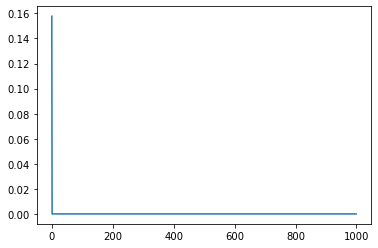

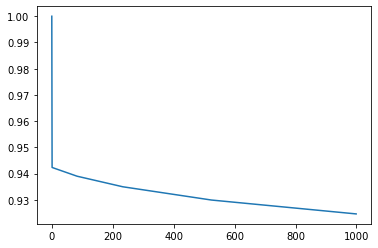

In [100]:
# Figure (dj_dk, cost  functional)
z = np.arange(0, Zmax-1, 1)
n_djdk = np.zeros([Zmax-1, r])
J_Tl = np.zeros([Zmax-1, r])
del id
for id in range(0, Zmax-1):
    norm_djdk = np.linalg.norm(djdk_pi[0:2*n+r,0:2*n+r,id])
    n_djdk[id,:] = norm_djdk
    J_T = Jc_pi[len(t)-1,:,id]
    J_Tl[id, :] = J_T
plt.figure()
plt.plot(z, n_djdk)
plt.figure()
plt.plot(z, J_Tl/J_Tl[0,0])

In [33]:
print(BK_pi[0:2*n+r,0:2*n+r,Zmax-1])
# Save results
np.save('ControlPIRL_QC.npy', BK_pi[0:2*n+r,0:2*n+r,Zmax-1])

[[-7.79277752e-02  1.29137212e-01  1.71262424e-02  2.12096048e-03
   2.31034768e-01]
 [ 1.29137212e-01 -1.79392076e+00 -8.75479687e-02 -1.49662557e-02
  -9.92633579e-01]
 [ 1.45274357e-02 -8.74435724e-02 -9.00517455e-02 -8.33386744e-04
  -1.72260033e-01]
 [ 2.29114141e-02 -1.58014257e-02  6.31822869e-01 -2.77906460e-02
  -3.58697350e-02]
 [ 2.31034768e-01 -9.92633579e-01 -1.73926700e-01 -2.25364016e-02
  -4.12058371e+00]]


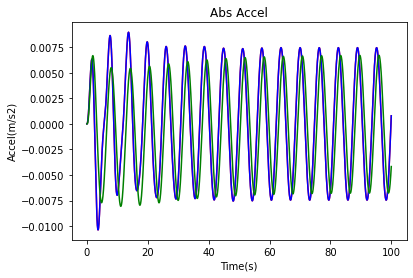

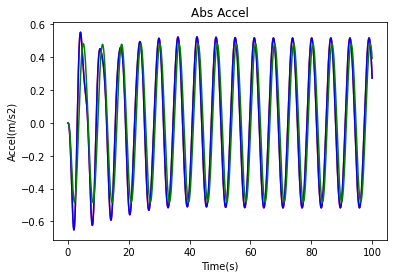

In [35]:
# Figure (Structural responses)
Cd2 = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [-Ks/M, Ks/M, 0, 0, 0], [Ks/m, -1*(Ks+Kt)/m, 0, 0, 0], [0, 0, 0, 0, 1]])
yp_z0 = (Cd2-BK_pi[0:2*n+r,0:2*n+r,0]) @ np.array([x_pi[:,:,0].T])
yp_zmax = (Cd2-BK_pi[0:2*n+r,0:2*n+r,Zmax-1]) @ np.array([x_pi[:,:,Zmax-2].T]) 

for i in range(0,len(Cdi)-1):
    plt.figure()
    plt.plot(t, ypi1[:,i],'r',t, ypi[:,i], 'b', t, yp_zmax[:,i+2,:].T,'g')
    plt.title('Abs Accel')
    plt.xlabel('Time(s)')
    plt.ylabel('Accel(m/s2)')
del i     


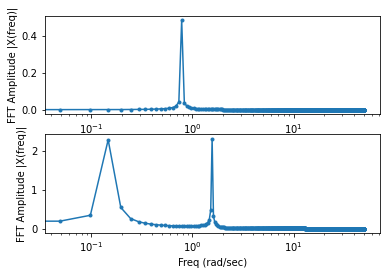

In [48]:
# Testing efficacy of the trained Rl-controller
# Input Road Profile
amplitude1   = 0.5*(np.sin(0.2*t) + np.sin(2*t))
len(t)
plt.figure()
plt.plot(t, amplitude1)
plt.title('Road profile')
plt.xlabel('Time(s)')
plt.ylabel('Input(m)')

# Fast fourier transform (FFT)
sr = 1/dt  # sampling frequency
N1 = 2046  # Number of samples
fstep = sr/N1  # freq interval
f = np.linspace(0, (N1-1)*fstep, N1)

# Perform FFT
X = np.fft.fft(amplitude)
X_mag = np.abs(X)/N1

X1 = np.fft.fft(amplitude1)
X1_mag = np.abs(X1)/N1

f_plot = f[0:int(N1/2+1)]
X_mag_plot = 2*X_mag[0:int(N1/2+1)]
X_mag_plot[0] = X_mag_plot[0] / 2 # DC component does not need to multiply by 2

X1_mag_plot = 2*X1_mag[0:int(N1/2+1)]
X1_mag_plot[0] = X1_mag_plot[0] / 2 # DC component does not need to multiply by 2

# Plot 
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
ax1.plot(f_plot, X_mag_plot, '.-')
ax2.plot(f_plot, X1_mag_plot, '.-')
ax2.set_xlabel('Freq (rad/sec)')
ax1.set_ylabel('FFT Amplitude |X(freq)|')
ax2.set_ylabel('FFT Amplitude |X(freq)|')
ax1.semilogx()
ax2.semilogx()
plt.show()

In [49]:
BKt = np.load('ControlPIRL_QC.npy')
Kdc = np.load('ControllerPI_QC.npy')
xt = np.zeros([len(t), 2*n+r])  # State
yt = np.zeros([len(t), len(Cd2)])  # State
print(BKt)
print(Kdc)
for tkk in range(0,len(t)-1):
    time_current = t[tkk]
    h = amplitude1[tkk] 
    xn = np.array([xt[tkk,:]]).T
#   print(xn)
    xn1 = dydx(FIc, BKt, BIrdc, 1, h, xn)
#     print(xn1)
    xt[tkk+1,:] = xn1.T
    yn1 = (Cd2-BKt) @ xn1
    yt[tkk+1,:] = yn1.T

[[-7.79277752e-02  1.29137212e-01  1.71262424e-02  2.12096048e-03
   2.31034768e-01]
 [ 1.29137212e-01 -1.79392076e+00 -8.75479687e-02 -1.49662557e-02
  -9.92633579e-01]
 [ 1.45274357e-02 -8.74435724e-02 -9.00517455e-02 -8.33386744e-04
  -1.72260033e-01]
 [ 2.29114141e-02 -1.58014257e-02  6.31822869e-01 -2.77906460e-02
  -3.58697350e-02]
 [ 2.31034768e-01 -9.92633579e-01 -1.73926700e-01 -2.25364016e-02
  -4.12058371e+00]]
[[ 25.72063416  -3.6930903  198.53017206  -8.65909908  -5.47722558]]


In [50]:
# Open loop and optimal control
sys_uc = signal.StateSpace(FIc, BIrdc, Cdi, np.array([[0, 0, 0]]).T)
sys_c = signal.StateSpace(FIc-gIc@Kdc, BIrdc, Cdi-Ddi@Kdc, np.array([[0, 0, 0]]).T)
t_c,yuct,xuct = signal.lsim(sys_uc,amplitude1,t)
t_c,yot,xot = signal.lsim(sys_c,amplitude1,t)

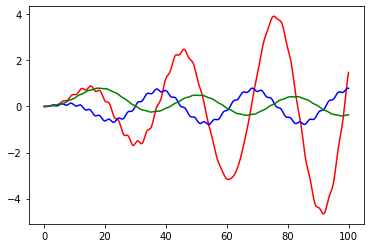

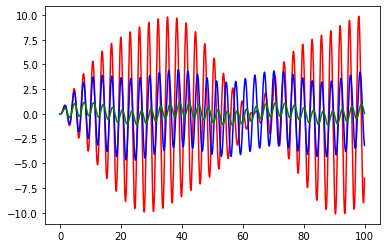

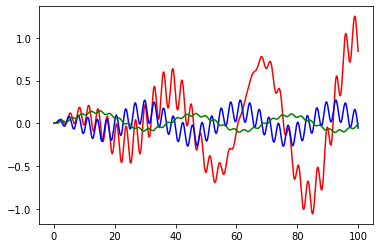

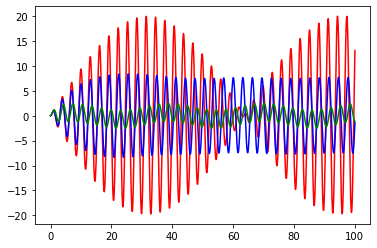

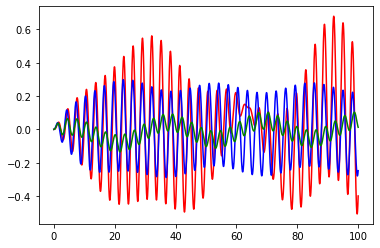

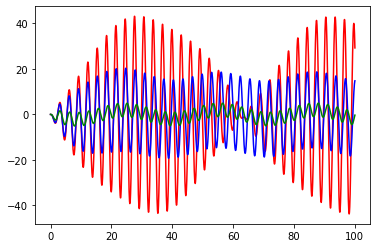

In [51]:
for i in range(2*n):
    plt.figure()
    plt.plot(t, xuct[:,i], 'r', t,xot[:,i],'b', t, xt[:,i],'g')
del i 
for i in range(0,len(Cdi)-1):
    plt.figure()
    plt.plot(t, yuct[:,i], 'r', t, yot[:,i],'b', t, yt[:,i+2],'g')

In [52]:
# Maximum value of response
print("Peak Dis of str - ", "Uncontrolled:", max(xuct[:,0], key=abs), "Optimal-PI:", max(xot[:,0], key=abs), "PG-PI:", max(xt[:,0], key=abs))
print("Peak Dis of Tyre - ", "Uncontrolled:", max(xuct[:,1], key=abs), "Optimal-PI:", max(xot[:,1], key=abs),"PG-PI:", max(xt[:,1], key=abs))
print("Peak Vel of str - ", "Uncontrolled:", max(xuct[:,2], key=abs), "Optimal-PI:", max(xot[:,2], key=abs), "PG-PI:", max(xt[:,2], key=abs))
print("Peak Vel of Tyre - ", "Uncontrolled:", max(xuct[:,3], key=abs), "Optimal-PI:", max(xot[:,3], key=abs),"PG-PI:", max(xt[:,3], key=abs))
print("Peak Acc of str - ", "Uncontrolled:", max(yuct[:,0], key=abs), "Optimal-PI:", max(yot[:,0], key=abs), "PG-PI:", max(yt[:,2], key=abs))
print("Peak Acc of Tyre - ", "Uncontrolled:", max(yuct[:,1], key=abs), "Optimal-PI:", max(yot[:,1], key=abs),"PG-PI:", max(yt[:,3], key=abs))

Peak Dis of str -  Uncontrolled: -4.667583557774823 Optimal-PI: 0.7952537718528558 PG-PI: 0.7982121126090129
Peak Dis of Tyre -  Uncontrolled: -10.121353295392323 Optimal-PI: -4.688641842561926 PG-PI: 1.176472193819763
Peak Vel of str -  Uncontrolled: 1.2515758825350456 Optimal-PI: 0.2718565038964762 PG-PI: 0.14527078708481703
Peak Vel of Tyre -  Uncontrolled: 19.951623056617013 Optimal-PI: 8.39182172728778 PG-PI: -2.527066099082888
Peak Acc of str -  Uncontrolled: 0.6787649042289153 Optimal-PI: 0.2984168253437804 PG-PI: -0.1352617130743921
Peak Acc of Tyre -  Uncontrolled: -43.71303766724039 Optimal-PI: 20.294451927715823 PG-PI: -5.085438563832752
